In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx  
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import cKDTree
from datetime import datetime
from matplotlib import gridspec
import scipy.stats as stats
import wavespectra
import netCDF4 as nc
import h5py
import numbers
import copy
from statsmodels.tsa.stattools import acf
#import 
%matplotlib inline

In [2]:
base_path = "/gpfs/work3/0/ai4nbs/hurry_wave/north_sea"
output_dir = os.path.join(base_path, "04_modelruns" , "YearSims", "01_postprocess", "plots","test")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# parser = argparse.ArgumentParser(description="Postprocess Hurrywave output.")
# parser.add_argument("--model_name", type=str, required=True, help="Name of the model run")
# parser.add_argument("--data_name", type=str, required=True, help="Name of the data set")
# args = parser.parse_args()

# model_name = args.model_name
# data_name = args.data_name

year_start = 2009 # Latest year
year_end = 2007 # Earliest year
years = np.arange(year_start, year_end, -1)



area = [65, -12, 48, 10] # DCSM area in the North Sea (degrees): North, West, South, East

# model_path = os.path.join(base_path, '04_modelruns', 'YearSims',model_name)
 
model_path = os.path.join(base_path, '04_modelruns', 'YearSims')
model_path_start = os.path.join(model_path, str(year_start)) 
postprocess_path = os.path.join(base_path, '05_postprocessing', 'his_files_per_station')

inp_file = os.path.join(model_path_start, 'hurrywave.inp')
tstart = None
tstop = None

# DCSM bounding box: [North, West, South, East]
area = [65, -12, 48, 10]  # (N, W, S, E)

# Find the start and stop times from the input file
with open(inp_file, 'r') as f:
    for line in f:
        if line.strip().startswith('tstart'):
            tstart = line.split('=')[1].strip()
        if line.strip().startswith('tstop'):
            tstop = line.split('=')[1].strip()
        if line.strip().startswith('tspinup'):
            tspinup = line.split('=')[1].strip()


# Ensure time is in "yyyymmdd hhmmss" format
def parse_time(s):
    parts = s.strip().split()
    if len(parts) == 2:
        date, time = parts
    elif len(parts) == 1:
        date = parts[0][:8]
        time = parts[0][8:] if len(parts[0]) > 8 else "000000"
    else:
        date, time = "00000000", "000000"  # fallback
    return f"{date} {time}"

tstart_str = parse_time(tstart)
tstop_str = parse_time(tstop)

tstart_dt = datetime.strptime(tstart_str, "%Y%m%d %H%M%S")
tstop_dt = datetime.strptime(tstop_str, "%Y%m%d %H%M%S")

In [3]:
def read_stations_from_obs(file_path):
    """
    Reads station coordinates and names from a .obs file.

    Returns:
        xs (list[float]): x coordinates
        ys (list[float]): y coordinates
        names (list[str]): station names
    """
    xs, ys, names = [], [], []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                parts = line.strip().split()
                x = float(parts[0])
                y = float(parts[1])
                name = " ".join(parts[3:])  # everything after "#"
                xs.append(x)
                ys.append(y)
                names.append(name)
    return xs, ys, names

# Example usage
obs_file_path = os.path.join(model_path_start, 'hurrywave.obs')
xs, ys, station_names = read_stations_from_obs(obs_file_path)

In [4]:
def his_remove_spinup(year, model_base_path, his):
    # Find the start and stop times from the input file
    inp_file = os.path.join(model_base_path, str(year), 'hurrywave.inp')
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('tspinup'):
                tspinup = line.split('=')[1].strip()

    tspinup_sec = int(tspinup)
    his_time_vals = his["time"].values
    spinup_end_time = his_time_vals[0] + np.timedelta64(tspinup_sec, 's')
    his_spinup_mask = his_time_vals >= spinup_end_time
    his = his.sel(time=his_spinup_mask)
    return his

In [5]:
def read_stations_from_obs(file_path):
    xs, ys, names = [], [], []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                parts = line.strip().split()
                x = float(parts[0])
                y = float(parts[1])
                name = " ".join(parts[3:])
                xs.append(x)
                ys.append(y)
                names.append(name)
    return xs, ys, names


def process_station_data(model_base_path, outdir, y0, y1, save=True):
    print('Starting Hurrywave station extraction...')

    years = np.arange(y0, y1 + 1)
    data_per_station = {}

    for y in years:
        print(f'Processing year: {y}')
        # Read station coordinates from obs file
        obs_file_path = os.path.join(model_base_path,str(y), 'hurrywave.obs')
        xs, ys, station_names_obs = read_stations_from_obs(obs_file_path)
        station_coord_map = {name: (x, y) for name, x, y in zip(station_names_obs, xs, ys)}
        fname = os.path.join(model_base_path, str(y), 'hurrywave_his.nc')
        ds = xr.open_dataset(fname)

        ds = his_remove_spinup(y, model_base_path, ds)

        nstations = ds.dims['stations']
        station_names = ds['station_name'].astype(str).values

        # Select only point variables with dims (time, stations)
        data_vars = [v for v in ds.data_vars if ds[v].dims == ('time', 'stations')]
        time = ds['time'].values

        for i in range(nstations):
            station = station_names[i].strip()
            print(f'  - Extracting {station}')

            if station not in data_per_station:
                data_per_station[station] = {var: [] for var in data_vars}
                data_per_station[station]['time'] = []

                # Add station coordinates
                data_per_station[station]['station_x'] = station_coord_map[station_names_obs[i]][0]
                data_per_station[station]['station_y'] = station_coord_map[station_names_obs[i]][1]

            # Append year’s data for each variable
            for var in data_vars:
                data_per_station[station][var].append(ds[var].isel(stations=i).values)
            data_per_station[station]['time'].append(time)

        ds.close()

    # Concatenate lists into arrays per station
    for station in data_per_station.keys():
        for key in data_per_station[station]:
            if isinstance(data_per_station[station][key], list) and key not in ('station_x', 'station_y'):
                data_per_station[station][key] = np.concatenate(data_per_station[station][key])

    if save:
        print('All years loaded. Starting export...')
        os.makedirs(outdir, exist_ok=True)

        for station, data in data_per_station.items():
            outpath = os.path.join(outdir, f'{station}.npz')
            np.savez(outpath, **data)
            print(f'  ✓ Saved {station}.npz with {len(data["time"])} timesteps.')

        print(f'Extraction finished. Data saved to: {outdir}')
    else:
        print(f'Extraction complete. Data not saved (save=False).')

    return data_per_station, station_names_obs

In [6]:
data_per_station, station_names = process_station_data(
    model_base_path=model_path,
    outdir=postprocess_path,
    y0=year_end,
    y1=year_start,
    save=False
)

Starting Hurrywave station extraction...
Processing year: 2007


/scratch-local/72649/ipykernel_3486771/975380268.py:33: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Processing year: 2008
  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008


/scratch-local/72649/ipykernel_3486771/975380268.py:33: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


Processing year: 2009
  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008


/scratch-local/72649/ipykernel_3486771/975380268.py:33: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


Extraction complete. Data not saved (save=False).


In [7]:
# Map station IDs to station names using the station_names list
station_ids = list(data_per_station.keys())
if len(station_ids) != len(station_names):
    raise ValueError(f"Number of station IDs ({len(station_ids)}) and station names ({len(station_names)}) do not match.")

else:
    data_per_station_named = {}
    for sid, sname in zip(station_ids, station_names):
        data_per_station_named[sname] = data_per_station[sid]
    data_per_station = data_per_station_named

In [8]:
print(data_per_station['K13 Alpha']['time'][0])

2007-01-01T00:00:00.000000000


dict_keys(['Euro platform', 'Platform D15-A', 'Platform Hoorn Q1-A', 'North Cormorant', 'K13 Alpha', 'Platform F16-A', 'IJmuiden munitiestortplaats', 'A12 platform'])


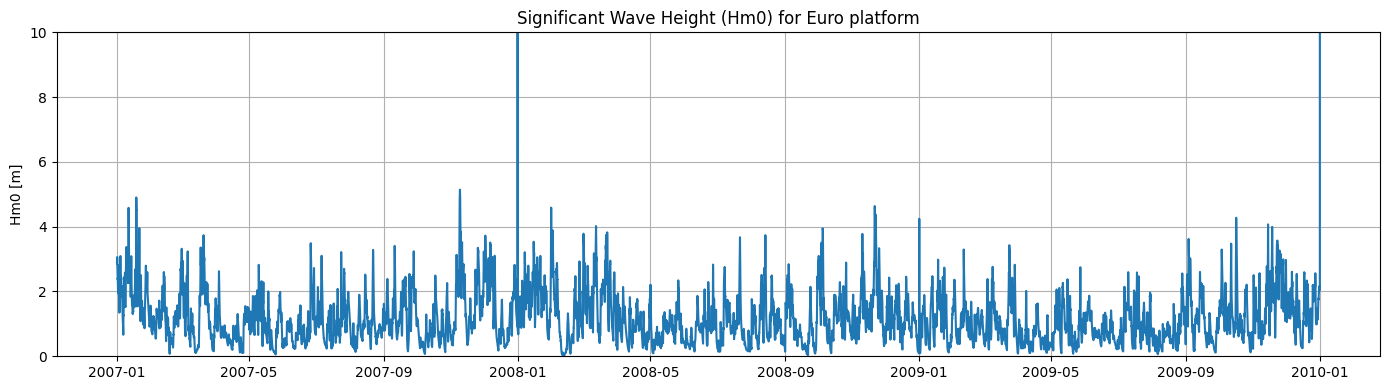

In [9]:
# Let's say you want to plot for station 'station_001'
station_id = 'Euro platform'
print(data_per_station.keys())
dset = data_per_station[station_id]

# Plot point_hm0 using numpy arrays
plt.figure(figsize=(14, 4))
plt.plot(dset['time'], dset['point_hm0'])
plt.title(f'Significant Wave Height (Hm0) for {station_id}')
plt.ylabel('Hm0 [m]')
plt.ylim(0, 10)  # Adjust as needed
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Path to Waterinfo_RWS data
waterinfo_base = os.path.join(base_path, "01_data", "Waterinfo_RWS")

# Collect all years available in Waterinfo_RWS
obs_years = sorted([d for d in os.listdir(waterinfo_base) if d.isdigit()])
# Only keep years from year_start down to year_end (inclusive)
obs_years = [year for year in obs_years if int(year) <= year_start and int(year) >= year_end]
obs_years = sorted(obs_years, reverse=True)  # Descending order: year_start to year_end

print(obs_years)
# Dictionary to hold all observational data per station
obs_data_per_station = {}

for year in obs_years:
    print(f"Loading observational data for year: {year}")
    year_dir = os.path.join(waterinfo_base, year)
    for fname in os.listdir(year_dir):
        if fname.endswith('.csv'):
            station = fname.replace('.csv', '')
            fpath = os.path.join(year_dir, fname)
            if not os.path.exists(fpath):
                print(f"File not found: {fpath}, skipping.")
                continue

            # Check if file is empty or contains no columns
            with open(fpath, 'r') as checkfile:
                first_line = checkfile.readline()
                if not first_line or len(first_line.strip().split(',')) < 2:
                    print(f"File {fpath} contains no columns, skipping.")
                    continue
            df = pd.read_csv(fpath, parse_dates=True)
            if df.empty:
                print(f"Skipping {fpath} as it contains no data records.")
                continue  # Skip file if no data record
            if df.empty or len(df) < 10:
                print(f"Skipping {fpath} as it contains no data records or less than 10 records.")
                continue  # Skip file if no data record or too few records
            df['year'] = int(year)
            if station not in obs_data_per_station:
                obs_data_per_station[station] = [df]
            else:
                obs_data_per_station[station].append(df)

    print(f"Finished loading observational data from Waterinfo_RWS for {len(obs_data_per_station)} stations.")

# Concatenate yearly dataframes for each station
for station in obs_data_per_station:
    obs_data_per_station[station] = pd.concat(obs_data_per_station[station], ignore_index=True)
    #divide all values of hm0 by 100 as they are in cm
    if 'hm0' in obs_data_per_station[station]:
        obs_data_per_station[station]['hm0'] = obs_data_per_station[station]['hm0'] / 100

    # t13 is divided by 0.95 to move to Tp
    if 't13' in obs_data_per_station[station]:
        obs_data_per_station[station]['t13'] = obs_data_per_station[station]['t13'] / 0.95

    # If the dataframe has
    # 'Unnamed: 0' as a column, rename it to 'time'
    for station in obs_data_per_station:
        if isinstance(obs_data_per_station[station], pd.DataFrame):
            if 'Unnamed: 0' in obs_data_per_station[station]:
                # Convert to pandas datetime first, then to numpy.datetime64 array
                print(station)
                time_pd = pd.to_datetime(obs_data_per_station[station].pop('Unnamed: 0'))
                obs_data_per_station[station]['time'] = time_pd.values.astype('datetime64[ns]')


# Now obs_data_per_station[station_name] contains all years of data for each station as a single DataFrame

['2009', '2008', '2007']
Loading observational data for year: 2009
Skipping /gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/Waterinfo_RWS/2009/K13 Alpha.csv as it contains no data records or less than 10 records.
Finished loading observational data from Waterinfo_RWS for 6 stations.
Loading observational data for year: 2008
Skipping /gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/Waterinfo_RWS/2008/Platform Hoorn Q1-A.csv as it contains no data records or less than 10 records.
Skipping /gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/Waterinfo_RWS/2008/Platform F16-A.csv as it contains no data records or less than 10 records.
Skipping /gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/Waterinfo_RWS/2008/Platform D15-A.csv as it contains no data records or less than 10 records.
Skipping /gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/Waterinfo_RWS/2008/K13 Alpha.csv as it contains no data records or less than 10 records.
Skipping /gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/W

In [11]:
print(data_per_station.keys())
print(obs_data_per_station.keys())

dict_keys(['Euro platform', 'Platform D15-A', 'Platform Hoorn Q1-A', 'North Cormorant', 'K13 Alpha', 'Platform F16-A', 'IJmuiden munitiestortplaats', 'A12 platform'])
dict_keys(['Platform Hoorn Q1-A', 'Platform F16-A', 'IJmuiden munitiestortplaats', 'Platform D15-A', 'North Cormorant', 'Euro platform'])


In [12]:
print(data_per_station.keys())
print(obs_data_per_station.keys())

dict_keys(['Euro platform', 'Platform D15-A', 'Platform Hoorn Q1-A', 'North Cormorant', 'K13 Alpha', 'Platform F16-A', 'IJmuiden munitiestortplaats', 'A12 platform'])
dict_keys(['Platform Hoorn Q1-A', 'Platform F16-A', 'IJmuiden munitiestortplaats', 'Platform D15-A', 'North Cormorant', 'Euro platform'])


In [13]:
print(obs_data_per_station['Euro platform'].keys())

Index(['hm0', 't13', 'tmax', 'year', 'time'], dtype='object')


In [14]:
# print(data_per_station['Euro platform'].keys())
# print(obs_data_per_station['Euro platform']['time'].values)

# Convert time strings to datetime, skip invalid formats
def safe_to_datetime(val):
    try:
        return pd.to_datetime(val)
    except Exception:
        return pd.NaT

obs_times = obs_data_per_station['Euro platform']['time']
# Convert to pandas datetime with timezone awareness, coerce errors
obs_times_dt = pd.to_datetime(obs_times, errors='coerce', utc=False)
# If some times are still not in the correct format, try parsing with exact format
if obs_times_dt.isnull().any():
    obs_times_dt = pd.to_datetime(obs_times, format='%Y-%m-%d %H:%M:%S%z', errors='coerce')

obs_data_per_station['Euro platform']['time'] = obs_times_dt



In [15]:
print(data_per_station['Euro platform']['time'].shape)
print(obs_data_per_station['Euro platform']['time'].shape)

(26307,)
(157395,)


In [16]:
print(obs_data_per_station['Euro platform'].keys())
# print(obs_data_per_station['A12 platform'].keys())

Index(['hm0', 't13', 'tmax', 'year', 'time'], dtype='object')


In [17]:
def synchronize_station_keys(model_dict, meas_dict):
    # 1. Merge "K13a platform" into "K13 Alpha" in meas_dict
    k13a_key = None
    for key in meas_dict.keys():
        if "k13a" in key.lower():
            k13a_key = key
            break

    if k13a_key is not None:
        target_key = "K13 Alpha"
        k13a_data = meas_dict.get(k13a_key)
        target_data = meas_dict.get(target_key)

        if isinstance(k13a_data, pd.DataFrame) and isinstance(target_data, pd.DataFrame):
            merged = pd.concat([k13a_data, target_data]).drop_duplicates()
        else:
            merged = target_data if target_data is not None else k13a_data

        meas_dict[target_key] = merged

        if k13a_key != target_key:
            del meas_dict[k13a_key]

    # 2. Determine reference columns from meas_dict (use first DataFrame found)
    ref_columns = None
    for data in meas_dict.values():
        if isinstance(data, pd.DataFrame):
            ref_columns = data.columns
            break

    if ref_columns is None:
        raise ValueError("No DataFrame found in meas_dict to use as reference for columns.")

    # 3. Add missing stations from model_dict into meas_dict with empty DataFrame
    for station in model_dict.keys():
        if station not in meas_dict:
            meas_dict[station] = pd.DataFrame(columns=ref_columns)

    # 4. Ensure all existing DataFrames have the same columns
    for station, data in meas_dict.items():
        if isinstance(data, pd.DataFrame):
            for col in ref_columns:
                if col not in data.columns:
                    data[col] = np.nan
            meas_dict[station] = data[ref_columns]  # reorder

    return model_dict, meas_dict

data_per_station, obs_data_per_station = synchronize_station_keys(data_per_station, obs_data_per_station)


In [18]:
print(obs_data_per_station['Euro platform'].keys())
print(obs_data_per_station['A12 platform'].keys())

Index(['hm0', 't13', 'tmax', 'year', 'time'], dtype='object')
Index(['hm0', 't13', 'tmax', 'year', 'time'], dtype='object')


In [19]:
print(data_per_station.keys())
print(obs_data_per_station.keys())

dict_keys(['Euro platform', 'Platform D15-A', 'Platform Hoorn Q1-A', 'North Cormorant', 'K13 Alpha', 'Platform F16-A', 'IJmuiden munitiestortplaats', 'A12 platform'])
dict_keys(['Platform Hoorn Q1-A', 'Platform F16-A', 'IJmuiden munitiestortplaats', 'Platform D15-A', 'North Cormorant', 'Euro platform', 'K13 Alpha', 'A12 platform'])


In [20]:
print(data_per_station['Euro platform']['time'][0])

2007-01-01T00:00:00.000000000


In [24]:
def remove_outliers(data_dict, varnames, threshold):
    """
    Remove all entries where the target variable exceeds the threshold.
    Works for both dict-of-DataFrame (obs) and dict-of-dicts (model).

    Args:
        data_dict (dict): Dictionary of station datasets.
        varnames (list of str): Possible keys for the variable (e.g. ["hm0", "point_hm0"]).
        threshold (float): Threshold value.
    """
    for station, dset in data_dict.items():
        # --- Case 1: whole dataset is a DataFrame ---
        if isinstance(dset, pd.DataFrame):
            for v in varnames:
                if v in dset:
                    # Only mask values where NOT NaN and > threshold; keep NaNs
                    if dset[v].empty:
                        print(f"Skipping {station} as {v} is empty.")
                        continue
                    mask = (dset[v].isna()) | (dset[v] <= threshold)
                    data_dict[station] = dset.loc[mask].copy()
                    break
            continue

        # --- Case 2: dataset is a dict of arrays/Series ---
        target = None
        for v in varnames:
            if v in dset:
                target = dset[v]
                break
        if target is None:
            continue  # no matching variable

        # Convert target to numpy array
        target_arr = target.values if hasattr(target, "values") else np.asarray(target)
        # Only mask values where NOT NaN and > threshold; keep NaNs
        if hasattr(target_arr, "size") and target_arr.size == 0:
            print(f"Skipping {station} as target array is empty.")
            continue
        mask = np.isnan(target_arr) | (target_arr <= threshold)

        for key, arr in dset.items():
            if hasattr(arr, "__len__") and not isinstance(arr, (str, bytes)) and len(arr) == len(mask):
                if isinstance(arr, pd.Series):
                    dset[key] = arr.iloc[mask]
                elif isinstance(arr, pd.DataFrame):
                    dset[key] = arr.iloc[mask, :]
                else:
                    dset[key] = np.asarray(arr)[mask]
            else:
                # leave scalars / metadata untouched
                dset[key] = arr

threshold_hm0 = 10
threshold_tp = 25

# Remove outliers for significant wave height
remove_outliers(data_per_station, ["hm0", "point_hm0"], threshold_hm0)
remove_outliers(obs_data_per_station, ["hm0", "point_hm0"], threshold_hm0)

# Remove outliers for peak period
remove_outliers(data_per_station, ["point_tp", "t13"], threshold_tp)
remove_outliers(obs_data_per_station, ["point_tp", "t13"], threshold_tp)

Skipping K13 Alpha as hm0 is empty.
Skipping A12 platform as hm0 is empty.
Skipping K13 Alpha as t13 is empty.
Skipping A12 platform as t13 is empty.


In [25]:
print(data_per_station['Euro platform']['time'][0])

2007-01-01T00:00:00.000000000


In [26]:
def convert_model_datetime(df_model):
    """
    Convert 'time' arrays in df_model dict to numpy datetime64[ns] using pandas for robustness.
    """
    for key in df_model.keys():
        if 'time' in df_model[key]:
            time_values = df_model[key]['time']
            
            # Convert pandas Series to numpy array if needed
            if isinstance(time_values, pd.Series):
                time_values = time_values.values
            
            # Wrap in pd.Series to ensure consistent behavior
            time_series = pd.Series(time_values)
            
            # Use pandas to_datetime to handle various formats, coerce errors to NaT
            time_pd = pd.to_datetime(time_series, errors='coerce')
            
            # Check for NaT values safely
            if time_pd.isna().any():
                print(f"Warning: Found invalid/missing times in station '{key}', these will become NaT.")
            
            # Convert to numpy datetime64[ns], keep NaT as numpy.datetime64('NaT')
            time_datetime = time_pd.values

            df_model[key]['time'] = time_datetime
            
    return df_model

data_per_station = convert_model_datetime(data_per_station)
print(data_per_station['Euro platform']['time'].dtype)
print(obs_data_per_station['Euro platform']['time'].dtype)

def common_times(arr1, arr2):
    """
    Return an array of common datetime64[ns] values between two arrays.

    Parameters:
    -----------
    arr1, arr2 : np.ndarray
        Arrays of dtype datetime64[ns]

    Returns:
    --------
    np.ndarray
        Sorted array containing common datetime64[ns] values.
    """
    return np.intersect1d(arr1, arr2)



def find_unique_common_time_indexes(df_model, df_measurements):
    common_indexes_dict = {}
    for station in df_model.keys():
        if station in df_measurements:
            print(station)

            model_times = df_model[station]['time']
            meas_times = df_measurements[station]['time']

            # If model_times or meas_times is a float (nan), convert to empty datetime64[ns] arrays
            if isinstance(model_times, float) or model_times is None or (isinstance(model_times, np.ndarray) and model_times.dtype == float):
                model_times = np.array([], dtype='datetime64[ns]')
            if isinstance(meas_times, float) or meas_times is None or (isinstance(meas_times, np.ndarray) and meas_times.dtype == float):
                meas_times = np.array([], dtype='datetime64[ns]')



            
            
            common = np.intersect1d(model_times, meas_times)

            # For each common time, find the index of its first occurrence in model and meas arrays
            model_idx = np.array([np.where(model_times == t)[0][0] for t in common])
            meas_idx = np.array([np.where(meas_times == t)[0][0] for t in common])

            common_indexes_dict[station] = {
                'model_idx': model_idx,
                'meas_idx': meas_idx
            }
    return common_indexes_dict

common_indexes_dict = find_unique_common_time_indexes(data_per_station, obs_data_per_station)

datetime64[ns]
datetime64[ns]
Euro platform
Platform D15-A
Platform Hoorn Q1-A
North Cormorant
K13 Alpha
Platform F16-A
IJmuiden munitiestortplaats
A12 platform


In [27]:
print(common_indexes_dict['K13 Alpha']['model_idx'])

[]


In [28]:
print(common_indexes_dict['Euro platform']['model_idx'].shape)
print(common_indexes_dict['Euro platform']['meas_idx'].shape)
print(data_per_station['Euro platform']['time'].shape)
print(obs_data_per_station['Euro platform']['time'].shape)

(26235,)
(26235,)
(26305,)
(157395,)


In [29]:
def filter_both_by_common_indexes(df_model, df_measurements, common_indexes_dict):
    """
    Make copies of model and measurement dictionaries and keep only the values
    at the indexes specified in common_indexes_dict for each station.
    """
    filtered_model = copy.deepcopy(df_model)
    filtered_measurements = {station: {k: v.copy(deep=True) if hasattr(v, 'copy') else copy.deepcopy(v)
                                   for k, v in inner.items()}
                         for station, inner in df_measurements.items()}

    for station, indexes in common_indexes_dict.items():
        model_idx = indexes.get('model_idx', [])
        meas_idx = indexes.get('meas_idx', [])

        print(f"\n--- Station: {station} ---")
        print(f"Model indexes count: {len(model_idx)}")
        print(f"Measurement indexes count: {len(meas_idx)}")

        # Convert indices to list of ints if they are numpy arrays or similar
        model_idx_list = list(model_idx) if len(model_idx) > 0 else []
        meas_idx_list = list(meas_idx) if len(meas_idx) > 0 else []

        # Model filtering
        for key, val in filtered_model[station].items():
            try:
                # Skip filtering if model_idx is empty or val is not indexable
                if not model_idx_list:
                    print(f"Model: Skipping key '{key}' because model_idx is empty")
                    continue

                # Check if val supports indexing by model_idx_list
                if hasattr(val, '__getitem__'):
                    filtered_val = val[model_idx_list]
                    filtered_model[station][key] = filtered_val
                    print(f"Model: Key '{key}' filtered shape: {getattr(filtered_val, 'shape', 'unknown')}")
                else:
                    print(f"Model: Key '{key}' is not indexable, skipping filtering")

            except Exception as e:
                print(f"Model: Error filtering key '{key}': {e}")

        # Measurement filtering
        for key, val in filtered_measurements[station].items():
            try:
                # Skip scalar values (e.g., float) that cannot be indexed
                if not hasattr(val, '__len__'):
                    print(f"Measurement: Key '{key}' is scalar or non-indexable, skipping filtering")
                    continue

                # Check if meas_idx is empty
                if not meas_idx_list:
                    print(f"Measurement: Skipping key '{key}' because meas_idx is empty")
                    model_len = len(filtered_model[station]['time'])
                    if isinstance(val, (pd.Series, pd.DataFrame)):
                        nan_val = np.full(model_len, np.nan)
                        if isinstance(val, pd.Series):
                            nan_val = pd.Series(nan_val, name=val.name)
                        else:
                            nan_val = pd.DataFrame({col: np.nan for col in val.columns}, index=range(model_len))
                        filtered_measurements[station][key] = nan_val
                    elif isinstance(val, np.ndarray):
                        filtered_measurements[station][key] = np.full(model_len, np.nan)
                    else:
                        filtered_measurements[station][key] = [np.nan] * model_len
                    continue

                val_type = type(val)
                val_len = len(val) if hasattr(val, '__len__') else 0
                print(f"Measurement before filtering: Key '{key}', type: {val_type}, length: {val_len}")

                # Validate indices are integers and in bounds (sample first 20)
                sample_idx = meas_idx_list[:20]
                idx_check = all(isinstance(idx, (int, np.integer)) and 0 <= idx < val_len for idx in sample_idx)
                print(f"Are all indices integer and within bounds? {idx_check}")
                if not idx_check:
                    print(f"Measurement: Invalid indices detected for key '{key}', skipping filtering")
                    continue

                # Filter according to type
                if isinstance(val, (pd.Series, pd.DataFrame)):
                    filtered_val = val.iloc[meas_idx_list].reset_index(drop=True)
                elif isinstance(val, np.ndarray):
                    filtered_val = val[meas_idx_list]
                else:
                    # Fallback for other iterable types like lists
                    filtered_val = [val[i] for i in meas_idx_list]

                filtered_measurements[station][key] = filtered_val

                filtered_type = type(filtered_val)
                filtered_shape = getattr(filtered_val, 'shape', 'unknown')
                print(f"Measurement: Key '{key}' filtered type: {filtered_type}, shape: {filtered_shape}")

                if isinstance(filtered_val, (pd.Series, pd.DataFrame)):
                    print(f"First 3 rows/values:\n{filtered_val.head(3)}")
                elif isinstance(filtered_val, (np.ndarray, list)):
                    print(f"First 3 values: {filtered_val[:3]}")

            except Exception as e:
                print(f"Measurement: Error filtering key '{key}': {e}")

    print("\n=== Summary of filtered results ===")
    for station in filtered_model.keys():
        print(f"Station: {station}")
        for key, val in filtered_model[station].items():
            print(f" Model key '{key}' shape: {getattr(val, 'shape', 'unknown')}")
        for key, val in filtered_measurements[station].items():
            print(f" Measurement key '{key}' shape: {getattr(val, 'shape', 'unknown')}")

    return filtered_model, filtered_measurements

data_per_station_filtered, obs_data_per_station_filtered = filter_both_by_common_indexes(data_per_station, obs_data_per_station, common_indexes_dict)


--- Station: Euro platform ---
Model indexes count: 26235
Measurement indexes count: 26235
Model: Key 'point_hm0' filtered shape: (26235,)
Model: Key 'point_tp' filtered shape: (26235,)
Model: Key 'point_wavdir' filtered shape: (26235,)
Model: Key 'point_dirspr' filtered shape: (26235,)
Model: Key 'point_depth' filtered shape: (26235,)
Model: Key 'wind_speed' filtered shape: (26235,)
Model: Key 'wind_direction' filtered shape: (26235,)
Model: Key 'time' filtered shape: (26235,)
Model: Key 'station_x' is not indexable, skipping filtering
Model: Key 'station_y' is not indexable, skipping filtering
Measurement before filtering: Key 'hm0', type: <class 'pandas.core.series.Series'>, length: 157395
Are all indices integer and within bounds? True
Measurement: Key 'hm0' filtered type: <class 'pandas.core.series.Series'>, shape: (26235,)
First 3 rows/values:
0    3.07
1    2.91
2    2.97
Name: hm0, dtype: float64
Measurement before filtering: Key 't13', type: <class 'pandas.core.series.Series'

In [30]:
print(obs_data_per_station['Platform D15-A']['hm0'])

0        2.50
1        2.62
2        3.00
3        3.06
4        3.01
         ... 
47875    2.98
47876    3.15
47877    3.14
47878    3.05
47879    3.00
Name: hm0, Length: 47880, dtype: float64


In [31]:
print(data_per_station['Platform D15-A']['point_hm0'].shape)
print(obs_data_per_station['Platform D15-A']['hm0'].shape)

(26305,)
(47880,)


In [32]:
for station in station_names:
    model_shape = None
    obs_shape = None
    # Model shape
    if 'point_hm0' in data_per_station_filtered.get(station, {}):
        model_val = data_per_station_filtered[station]['point_hm0']
        model_shape = model_val.shape if hasattr(model_val, 'shape') else (len(model_val),)
    # Observation shape
    if 'hm0' in obs_data_per_station_filtered.get(station, {}):
        obs_val = obs_data_per_station_filtered[station]['hm0']
        obs_shape = obs_val.shape if hasattr(obs_val, 'shape') else (len(obs_val),)
    print(f"{station:30s} | model hm0: {model_shape} | obs hm0: {obs_shape}")

Euro platform                  | model hm0: (26235,) | obs hm0: (26235,)
Platform D15-A                 | model hm0: (7980,) | obs hm0: (7980,)
Platform Hoorn Q1-A            | model hm0: (7978,) | obs hm0: (7978,)
North Cormorant                | model hm0: (78,) | obs hm0: (78,)
K13 Alpha                      | model hm0: (26305,) | obs hm0: (26305,)
Platform F16-A                 | model hm0: (7980,) | obs hm0: (7980,)
IJmuiden munitiestortplaats    | model hm0: (26235,) | obs hm0: (26235,)
A12 platform                   | model hm0: (26306,) | obs hm0: (26306,)


In [33]:
# def Remove_outliers(data_dict, obs_data_dict, thresholds):
#     model_keys = {"hm0": "point_hm0", "tp": "point_tp"}
#     obs_keys = {"hm0": "hm0", "tp": "t13"}

#     for station in data_dict:
#         model = data_dict[station]
#         obs = obs_data_dict.get(station, {})

#         if "time" not in model or "time" not in obs:
#             continue

#         # Build a combined DataFrame
#         df = pd.DataFrame({
#             "hm0_model": model.get(model_keys["hm0"], np.array([])),
#             "tp_model": model.get(model_keys["tp"], np.array([])),
#             "hm0_obs": obs.get(obs_keys["hm0"], np.array([])),
#             "tp_obs": obs.get(obs_keys["tp"], np.array([])),
#             "time_model": model["time"],
#             "time_obs": obs["time"]
#         })

#         # Ensure lengths match
#         min_len = min(len(df), len(df["hm0_obs"]))
#         df = df.iloc[:min_len]

#         # Step 1: filter model thresholds
#         for var, threshold in thresholds.items():
#             mcol = f"{var}_model"
#             ocol = f"{var}_obs"

#             mask_model = df[mcol] <= threshold

#             # Remove obs where model was removed (but only non-empty obs)
#             mask_obs = mask_model.copy()
#             mask_obs[df[ocol].isna()] = True  # preserve NaNs in obs

#             df = df[mask_obs]

#         # Step 2: filter obs thresholds
#         for var, threshold in thresholds.items():
#             mcol = f"{var}_model"
#             ocol = f"{var}_obs"

#             # Outliers in obs (not NaN) remove the row entirely
#             mask_keep = (df[ocol].isna()) | (df[ocol] <= threshold)
#             df = df[mask_keep]

#         # Update model and obs dicts
#         for k in model_keys.values():
#             col = "hm0_model" if "hm0" in k else "tp_model"
#             model[k] = df[col].to_numpy()
#         model["time"] = df["time_model"].to_numpy()

#         for k in obs_keys.values():
#             col = "hm0_obs" if "hm0" in k else "tp_obs"
#             obs[k] = df[col].to_numpy()
#         obs["time"] = df["time_obs"].to_numpy()

#     return data_dict, obs_data_dict

# thresholds = {"hm0": 10, "tp": 25} # Cap hm0 at 10m and tp at 25s
# data_per_station_filtered_2, obs_data_per_station_filtered_2 = Remove_outliers(data_per_station_filtered, obs_data_per_station_filtered, thresholds)

In [34]:
# for station in station_names:
#     model_shape = None
#     obs_shape = None
#     # Model shape
#     if 'point_hm0' in data_per_station_filtered_2.get(station, {}):
#         model_val = data_per_station_filtered_2[station]['point_hm0']
#         model_shape = model_val.shape if hasattr(model_val, 'shape') else (len(model_val),)
#     # Observation shape
#     if 'hm0' in obs_data_per_station_filtered_2.get(station, {}):
#         obs_val = obs_data_per_station_filtered_2[station]['hm0']
#         obs_shape = obs_val.shape if hasattr(obs_val, 'shape') else (len(obs_val),)
#     print(f"{station:30s} | model hm0: {model_shape} | obs hm0: {obs_shape}")

In [35]:
print(common_indexes_dict['Euro platform']['model_idx'].shape)
print(common_indexes_dict['Euro platform']['meas_idx'].shape)
print(data_per_station_filtered['Euro platform']['time'].shape)
print(obs_data_per_station_filtered['Euro platform']['time'].shape)

(26235,)
(26235,)
(26235,)
(26235,)


In [36]:
data_per_station.clear()
obs_data_per_station.clear()
data_per_station.update(data_per_station_filtered)
obs_data_per_station.update(obs_data_per_station_filtered)

In [37]:
print(obs_data_per_station['Euro platform'].keys())

dict_keys(['hm0', 't13', 'tmax', 'year', 'time'])


In [38]:
print(common_indexes_dict['Euro platform']['model_idx'].shape)
print(common_indexes_dict['Euro platform']['meas_idx'].shape)
print(data_per_station['Euro platform']['time'].shape)
print(obs_data_per_station['Euro platform']['time'].shape)

(26235,)
(26235,)
(26235,)
(26235,)


In [39]:
print(data_per_station['Euro platform'].keys())
print(obs_data_per_station['Euro platform'].keys())

dict_keys(['point_hm0', 'point_tp', 'point_wavdir', 'point_dirspr', 'point_depth', 'wind_speed', 'wind_direction', 'time', 'station_x', 'station_y'])
dict_keys(['hm0', 't13', 'tmax', 'year', 'time'])


In [40]:
print(data_per_station['Euro platform']['point_hm0'].shape)
print(obs_data_per_station['Euro platform']['hm0'].shape)

(26235,)
(26235,)


In [41]:
print(data_per_station['Platform D15-A']['point_hm0'].max())
print(obs_data_per_station['Platform D15-A']['hm0'].max())

5.437867
5.89


In [42]:
pinball_quantiles = [0.05,0.1, 0.25, 0.5, 0.75, 0.9,0.95]


def _filter_valid_pairs(obs, pred):
    """Return obs and pred with NaNs removed (only keep entries where both are finite)."""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    mask = np.isfinite(obs) & np.isfinite(pred)
    if not np.any(mask):  # No valid data
        return np.array([]), np.array([])
    return obs[mask], pred[mask]

def rmse(obs, pred):
    """Root Mean Square Error with NaN handling"""
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return np.nan
    return np.sqrt(np.mean((pred - obs) ** 2))

def bias(obs, pred):
    """Mean Bias (Mean Error) with NaN handling"""
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return np.nan
    return np.mean(pred - obs)

def scatter_index(obs, pred):
    """Scatter Index: RMSE normalized by mean of observations, NaN safe"""
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return np.nan
    return rmse(obs, pred) / np.mean(obs)

def pinball_loss(obs, pred, quantile_pinball=0.5):
    """Pinball Loss Function for a given quantile, NaN safe"""
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return np.nan
    delta = obs - pred
    return np.mean(np.maximum(quantile_pinball * delta, (quantile_pinball - 1) * delta))

def pinball_loss_from_list(obs, pred, quantile_pinball_list):
    """Compute pinball loss for a list of quantiles, NaN safe"""
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return [np.nan] * len(quantile_pinball_list)
    losses = []
    delta = obs - pred
    for q in quantile_pinball_list:
        loss = np.mean(np.maximum(q * delta, (q - 1) * delta))
        losses.append(loss)
    return losses
def calculate_statistics(obs, pred,  quantile_pinball, print_stats=True):
    """Calculate RMSE, Bias, Scatter Index, and Pinball Loss for a given list of quantiles"""
    rmse_value = rmse(obs, pred) 
    bias_value = bias(obs, pred)
    scatter_index_value = scatter_index(obs, pred)
    pinball_loss_values = pinball_loss_from_list(obs, pred, quantile_pinball)

    # Print the statistics
    if print_stats:
        print(f"RMSE: {rmse_value:.4f}")
        print(f"Bias: {bias_value:.4f}")
        print(f"Scatter Index: {scatter_index_value:.4f}")
        for quantile, pinball_loss_value in zip(quantile_pinball, pinball_loss_values):
            print(f"Pinball Loss for quantile {quantile}: {pinball_loss_value:.4f}")

    return rmse_value, bias_value, scatter_index_value, pinball_loss_values

variable_mapping_era5 = {
    'point_hm0': 'swh',  
    'point_tp': 'pp1d',   
    # 'point_wavdir': 'mwd',    
}

variable_mapping_measurements = {
    'point_hm0': 'hm0',
    'point_tp': 't13',
}

def map_variable_era5(variable):
    return variable_mapping_era5.get(variable, variable)

def map_list_of_variables_era5(variable_list):
    """
    Maps a list of variable names to their corresponding variables in the dataset.
    """
    return [map_variable_era5(var) for var in variable_list]


def map_variable_measurements(variable):
    return variable_mapping_measurements.get(variable, variable)

def map_list_of_variables_measurements(variable_list):
    """
    Maps a list of variable names to their corresponding variables in the dataset.
    """
    return [map_variable_measurements(var) for var in variable_list]


def make_list_of_variables(variable_mapping):
    """
    Maps a list of variable names to their corresponding variables in the dataset.

    Args:
        variable_list (list): The list of variable names to map.

    Returns:
        list: The list of original variable names (1st column of the mapping).
    """
    return list(variable_mapping.keys())

variable_list = make_list_of_variables(variable_mapping_era5)
era5_variable_list = map_list_of_variables_era5(variable_list)
measurement_variable_list = map_list_of_variables_measurements(variable_list)

def compute_statistics_for_all(observed_dict, predicted_dict, quantile_pinball):
    """
    Compute statistics for all stations and variables, comparing model to observations.

    Parameters:
    - observed_dict: nested dict like obs[station][variable] = values
    - predicted_dict: nested dict like pred[station][variable] = values
    - quantile_pinball: list of quantiles to use in pinball loss

    Returns:
    - df_statistics[station][variable][statistic][benchmark] = value
    """
    df_statistics = {}

    for station in observed_dict:
        df_statistics[station] = {}

        for variable in observed_dict[station]:
            obs = observed_dict[station][variable]
            pred = predicted_dict[station][variable]

            # Compute statistics
            rmse_val, bias_val, si_val, pinball_vals = calculate_statistics(
                obs, pred, quantile_pinball=quantile_pinball, print_stats=False
            )

            # Store in nested dict
            df_statistics[station][variable] = {
                'RMSE': {'model_vs_obs': rmse_val},
                'Bias': {'model_vs_obs': bias_val},
                'Scatter Index': {'model_vs_obs': si_val},
            }
            for idx, q in enumerate(quantile_pinball):
                df_statistics[station][variable][f'Pinball Loss (q={q})'] = {'model_vs_obs': pinball_vals[idx]}

    return df_statistics

def compute_benchmark_statistics(
    model_dict,
    model_vars,
    era5_dict=None,
    buoy_dict=None,
    benchmarks=["buoy"],
    quantile_pinball=[],
    variable_mapping_era5=variable_mapping_era5,
    variable_mapping_measurement = variable_mapping_measurements,
):
    """
    Compute statistics comparing model data to selected benchmarks (ERA5 and/or buoys),
    only for a selected list of model variables.

    Parameters:
        model_dict: nested dict model[station][variable] = values
        model_vars: list of variables to compute statistics on (e.g. ["swh", "mwp"])
        era5_dict: optional, same structure as model_dict
        buoy_dict: optional, same structure as model_dict
        benchmarks: list of "era5", "buoy", or both
        quantile_pinball: list of quantiles for pinball loss
        map_variable_era5: function(str) -> str
        map_variable_buoy: function(str) -> str

    Returns:
        df_stats[station][model_variable][statistic][benchmark] = value
    """
    df_stats = {}

    for station in model_dict:
        df_stats[station] = {}

        for model_var in model_vars:
            if model_var not in model_dict[station]:
                continue

            model_values = model_dict[station][model_var]
            df_stats[station][model_var] = {}

            # === ERA5 benchmark ===
            if "era5" in benchmarks and era5_dict is not None:
                era5_var = map_variable_era5(model_var)
                if era5_var in era5_dict.get(station, {}):
                    obs_values = era5_dict[station][era5_var]

                    rmse_, bias_, si_, pinball_ = calculate_statistics(
                        obs_values, model_values,
                        quantile_pinball=quantile_pinball,
                        print_stats=False
                    )

                    df_stats[station][model_var].setdefault("RMSE", {})["era5"] = rmse_
                    df_stats[station][model_var].setdefault("Bias", {})["era5"] = bias_
                    df_stats[station][model_var].setdefault("Scatter Index", {})["era5"] = si_

                    counter = 0
                    for q in quantile_pinball:
                        df_stats[station][model_var].setdefault(f"Pinball Loss (q={q})", {})["era5"] = pinball_[counter]
                        counter += 1

            # === Buoy benchmark ===
            if "buoy" in benchmarks and buoy_dict is not None:
                buoy_var = map_variable_measurements(model_var)
                if buoy_var in buoy_dict.get(station, {}):
                    obs_values = buoy_dict[station][buoy_var]

                    if obs_values is not None and np.size(obs_values) > 0:
                        print(f"Buoy benchmark statistics for station {station}, variable {model_var}")
                        rmse_, bias_, si_, pinball_ = calculate_statistics(
                            obs_values, model_values,
                            quantile_pinball=quantile_pinball,
                            print_stats=False
                        )
                    else:
                        rmse_ = np.nan
                        bias_ = np.nan
                        si_ = np.nan
                        pinball_ = [np.nan] * len(quantile_pinball)

                    df_stats[station][model_var].setdefault("RMSE", {})["buoy"] = rmse_
                    df_stats[station][model_var].setdefault("Bias", {})["buoy"] = bias_
                    df_stats[station][model_var].setdefault("Scatter Index", {})["buoy"] = si_
                    
                    for idx, q in enumerate(quantile_pinball):
                        df_stats[station][model_var].setdefault(f"Pinball Loss (q={q})", {})["buoy"] = pinball_[idx]

    return df_stats

df_statistics = compute_benchmark_statistics(
    data_per_station,
    variable_list,
    era5_dict=None,
    buoy_dict=obs_data_per_station,	 
    quantile_pinball=pinball_quantiles,
    benchmarks=["buoy"],
    variable_mapping_era5=variable_mapping_era5,
    variable_mapping_measurement=variable_mapping_measurements

)

Buoy benchmark statistics for station Euro platform, variable point_hm0
Buoy benchmark statistics for station Euro platform, variable point_tp
Buoy benchmark statistics for station Platform D15-A, variable point_hm0
Buoy benchmark statistics for station Platform D15-A, variable point_tp
Buoy benchmark statistics for station Platform Hoorn Q1-A, variable point_hm0
Buoy benchmark statistics for station Platform Hoorn Q1-A, variable point_tp
Buoy benchmark statistics for station North Cormorant, variable point_hm0
Buoy benchmark statistics for station North Cormorant, variable point_tp
Buoy benchmark statistics for station K13 Alpha, variable point_hm0
Buoy benchmark statistics for station K13 Alpha, variable point_tp
Buoy benchmark statistics for station Platform F16-A, variable point_hm0
Buoy benchmark statistics for station Platform F16-A, variable point_tp
Buoy benchmark statistics for station IJmuiden munitiestortplaats, variable point_hm0
Buoy benchmark statistics for station IJmuid

In [43]:
print(variable_list)
print(variable_list[0])
print(map_variable_measurements(variable_list[0]))
print(data_per_station['Euro platform'].keys())

['point_hm0', 'point_tp']
point_hm0
hm0
dict_keys(['point_hm0', 'point_tp', 'point_wavdir', 'point_dirspr', 'point_depth', 'wind_speed', 'wind_direction', 'time', 'station_x', 'station_y'])


In [44]:
print(df_statistics['Platform Hoorn Q1-A']['point_hm0']['RMSE']['buoy'])

0.24223463841913617


In [45]:
for station in station_names:
    model_shape = None
    obs_shape = None
    # Model shape
    if 'point_hm0' in data_per_station.get(station, {}):
        model_val = data_per_station[station]['point_hm0']
        model_shape = model_val.shape if hasattr(model_val, 'shape') else (len(model_val),)
    # Observation shape
    if 'hm0' in obs_data_per_station.get(station, {}):
        obs_val = obs_data_per_station[station]['hm0']
        obs_shape = obs_val.shape if hasattr(obs_val, 'shape') else (len(obs_val),)
    print(f"{station:30s} | model hm0: {model_shape} | obs hm0: {obs_shape}")

Euro platform                  | model hm0: (26235,) | obs hm0: (26235,)
Platform D15-A                 | model hm0: (7980,) | obs hm0: (7980,)
Platform Hoorn Q1-A            | model hm0: (7978,) | obs hm0: (7978,)
North Cormorant                | model hm0: (78,) | obs hm0: (78,)
K13 Alpha                      | model hm0: (26305,) | obs hm0: (26305,)
Platform F16-A                 | model hm0: (7980,) | obs hm0: (7980,)
IJmuiden munitiestortplaats    | model hm0: (26235,) | obs hm0: (26235,)
A12 platform                   | model hm0: (26306,) | obs hm0: (26306,)


In [46]:

def plot_station_data_comparison(
    station_name,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    output_dir=output_dir,
    show_map=True  # new argument to control map display
):
    """
    Plot time series for selected variables at a single station, comparing model, ERA5, and/or buoy data.
    Includes a map with the station location and a side panel showing statistical metrics.

    Parameters:
        station_name (str): Name of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
        variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
        show_map (bool): Whether to show the map above the plots.
    """
    if model_vars is None:
        model_vars = list(model_df.get(station_name, {}).keys())

    n_vars = len(model_vars)
    plot_height = 0.18
    plot_space = 0.04  # space between plots

    if show_map:
        fig_height = 0.8 + n_vars * (plot_height + plot_space)
        fig = plt.figure(figsize=(14, 3 * n_vars + 5))
        fig.suptitle(f'Data Comparison at {station_name}', fontsize=16)

        # Adjust map position
        map_ax = fig.add_axes([0.05, 0.8, 0.6, 0.15])
        m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                    llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
        m.drawcoastlines()
        m.fillcontinents(color='lightgray', lake_color='aqua')
        m.drawmapboundary(fill_color='aqua')

        lat = float(model_df[station_name]["station_y"])
        lon = float(model_df[station_name]["station_x"])
        x, y = m(lon, lat)
        m.plot(x, y, 'ro', markersize=8)
        map_ax.text(x, y, f' {station_name}', fontsize=10, color='black')

        # Adjust time series plots position
        axs = []
        stat_axs = []
        for i in range(n_vars):
            bottom = 0.6 - i * (plot_height + plot_space)
            ax = fig.add_axes([0.05, bottom, 0.6, plot_height])
            axs.append(ax)
            stat_ax = fig.add_axes([0.7, bottom, 0.25, plot_height])
            stat_axs.append(stat_ax)
    else:
        # Place plots directly under the title, evenly spaced, with enough space for text
        fig_height = 0.2 + n_vars * (plot_height + plot_space)
        fig = plt.figure(figsize=(14, 3 * n_vars + 2))
        fig.suptitle(f'Data Comparison at {station_name}', fontsize=16)
        axs = []
        stat_axs = []
        for i in range(n_vars):
            # Start just below the title, leave enough space between plots
            # Increase bottom margin for more space below the last plot
            extra_space = 0.08  # add extra space below all plots
            bottom = 0.75 - i * (plot_height + plot_space) - extra_space * i / (n_vars - 1) if n_vars > 1 else 0.75
            ax = fig.add_axes([0.05, bottom, 0.6, plot_height])
            axs.append(ax)
            stat_ax = fig.add_axes([0.7, bottom, 0.25, plot_height])
            stat_axs.append(stat_ax)

    time = model_df[station_name]["time"]

    for i, var in enumerate(model_vars):
        ax = axs[i]
        stat_ax = stat_axs[i]
        ax.grid(True)

        # Model
        if var in model_df[station_name]:
            print(f"Plotting {var} for model at {station_name}")
            ax.plot(time, model_df[station_name][var], label="Model", color='blue')

        # ERA5
        if "era5" in benchmarks and era5_df:
            era5_var = map_variable_era5.get(var, var) if map_variable_era5 else var
            if era5_var in era5_df.get(station_name, {}):
                ax.plot(time, era5_df[station_name][era5_var], label="ERA5", linestyle='--', color='green')

        # Buoy
        if "buoy" in benchmarks and buoy_df:
            buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var
            if buoy_var in buoy_df.get(station_name, {}) and np.size(buoy_df[station_name][buoy_var]) == np.size(time):
                ax.plot(time, buoy_df[station_name][buoy_var], label="Buoy", linestyle=':', color='orange')

        ax.set_title(var)
        ax.set_ylabel(var)
        ax.legend()

        # Display statistics
        stat_ax.axis('off')
        if df_statistics and station_name in df_statistics and var in df_statistics[station_name]:
            lines = []
            stat_data = df_statistics[station_name][var]
            for stat in stat_data:
                line = f"{stat.capitalize()}"
                for source in benchmarks:
                    if source in stat_data[stat]:
                        val = stat_data[stat][source]
                        line += f" ({source}): {val:.3f} ;"
                line = line.rstrip(" ;")
                lines.append(line)
            stat_ax.text(0, 1, '\n'.join(lines), fontsize=9, va='top')

    axs[-1].set_xlabel("Time")
    output_path = os.path.join(output_dir, f'His_graph_at_{station_name}.png')
    fig.savefig(output_path, dpi=300, bbox_inches='tight')

def plot_all_stations(
    station_names,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    output_dir=output_dir,
    show_map=True):

    """
    Plot time series for selected variables at all stations, comparing model, ERA5, and/or buoy data.
    Includes a map with the station locations and a side panel showing statistical metrics.
    Parameters:
        station_names (list of str): Names of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
        variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
    """
    
    for station_name in station_names:
        plot_station_data_comparison(
            station_name,
            model_df,
            era5_df=era5_df,
            buoy_df=buoy_df,
            model_vars=model_vars,
            benchmarks=benchmarks,
            map_variable_era5=map_variable_era5,
            map_variable_buoy=map_variable_buoy,
            df_statistics=df_statistics,
            output_dir=output_dir,
            show_map=show_map
        )

plot_all_stations(
    station_names=station_names,
    model_df=data_per_station,
    buoy_df=obs_data_per_station,
    model_vars=variable_list,
    benchmarks=["buoy"],
    map_variable_era5=variable_mapping_era5,
    map_variable_buoy=variable_mapping_measurements,
    df_statistics=df_statistics,
    output_dir=output_dir,
    show_map=False
)



Plotting point_hm0 for model at Euro platform
Plotting point_tp for model at Euro platform
Plotting point_hm0 for model at Platform D15-A
Plotting point_tp for model at Platform D15-A
Plotting point_hm0 for model at Platform Hoorn Q1-A
Plotting point_tp for model at Platform Hoorn Q1-A
Plotting point_hm0 for model at North Cormorant
Plotting point_tp for model at North Cormorant
Plotting point_hm0 for model at K13 Alpha
Plotting point_tp for model at K13 Alpha
Plotting point_hm0 for model at Platform F16-A
Plotting point_tp for model at Platform F16-A
Plotting point_hm0 for model at IJmuiden munitiestortplaats
Plotting point_tp for model at IJmuiden munitiestortplaats
Plotting point_hm0 for model at A12 platform
Plotting point_tp for model at A12 platform


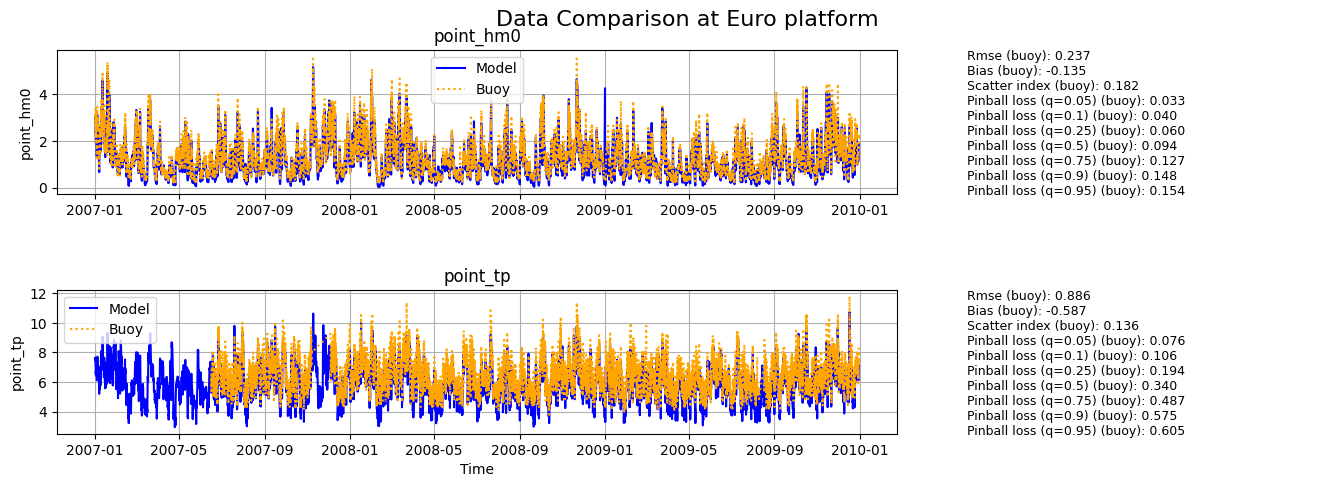

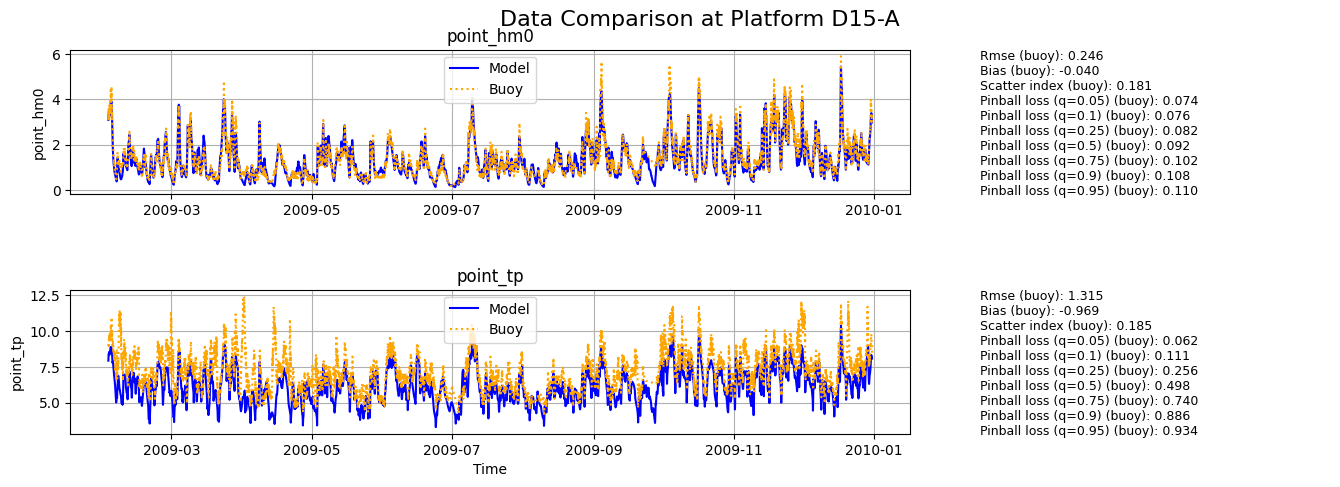

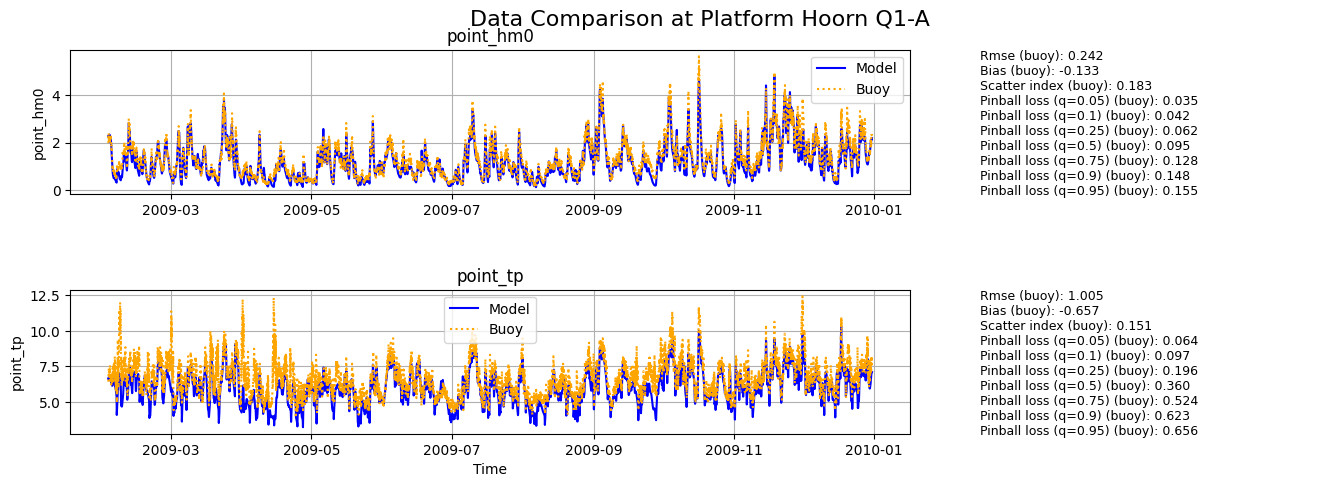

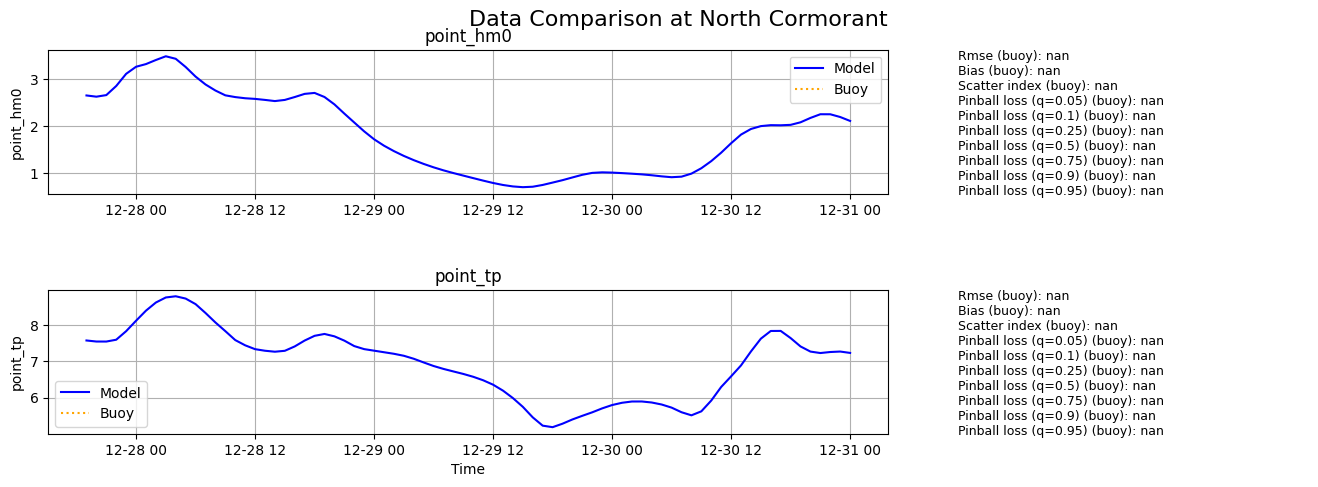

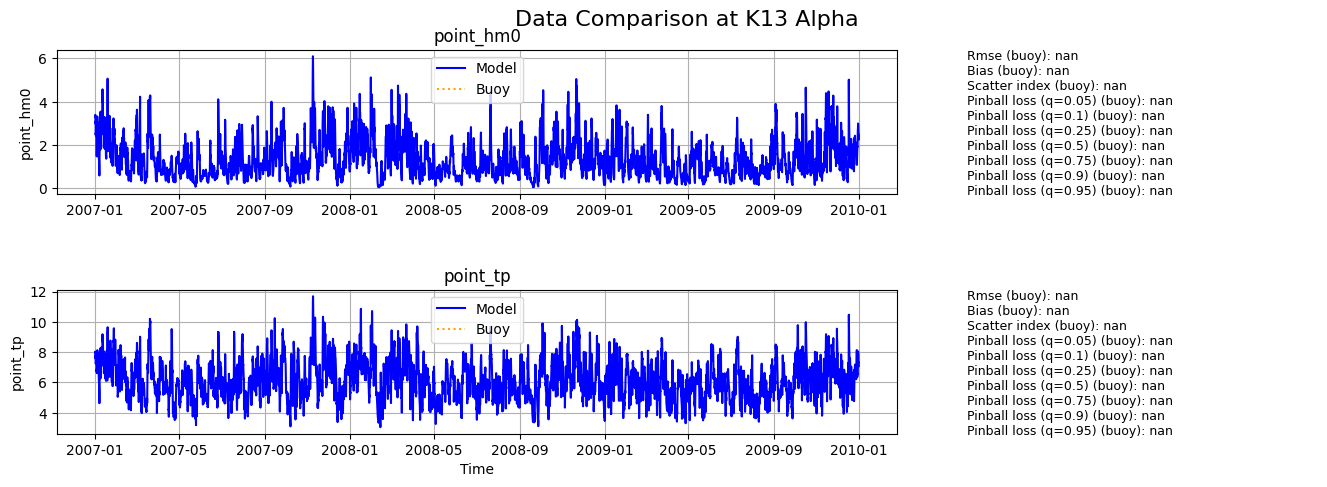

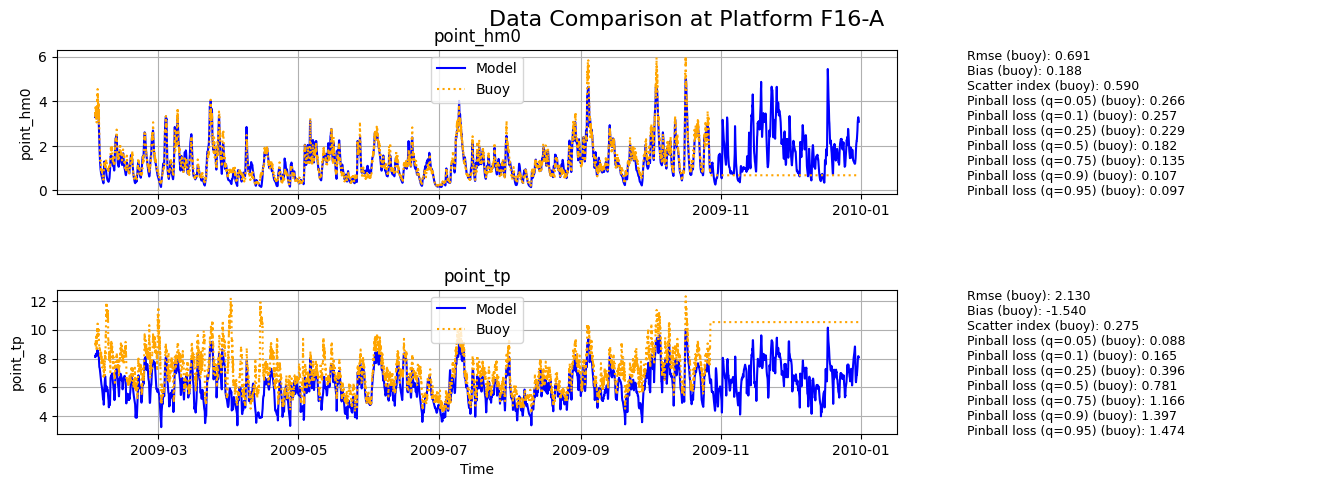

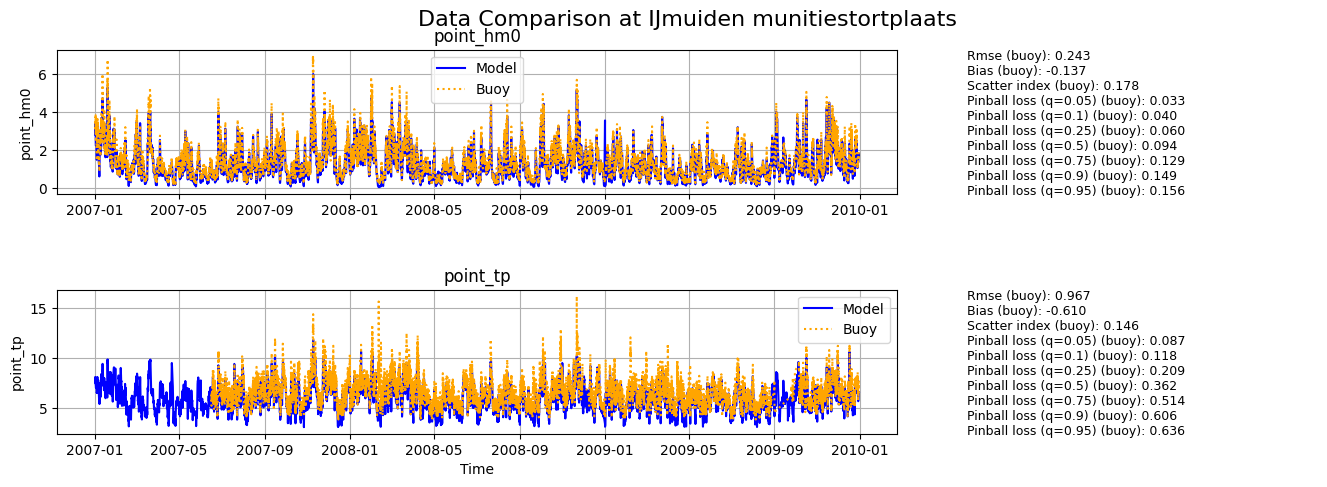

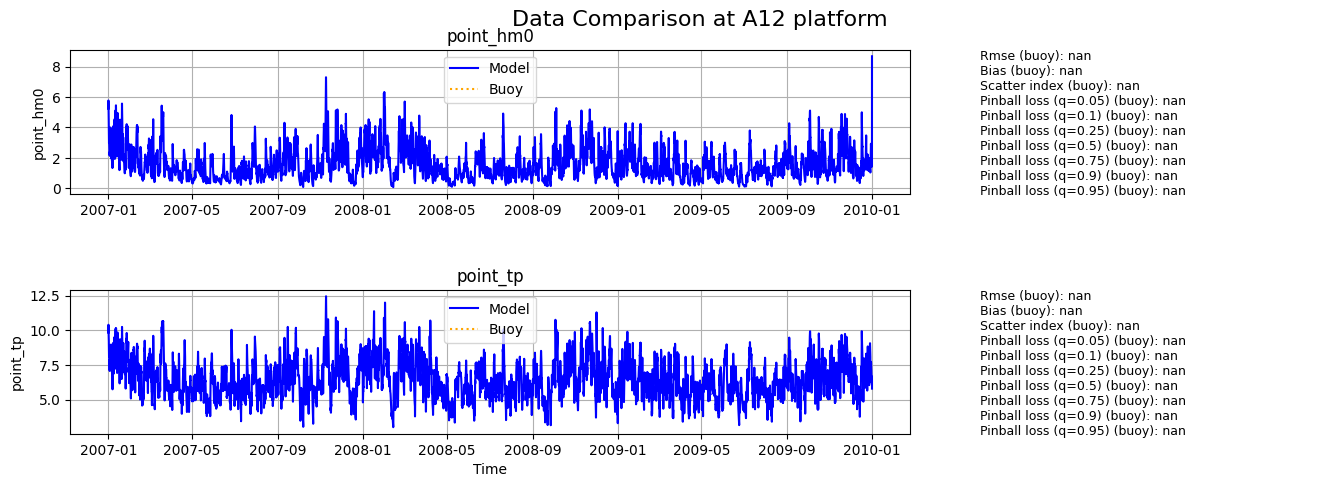

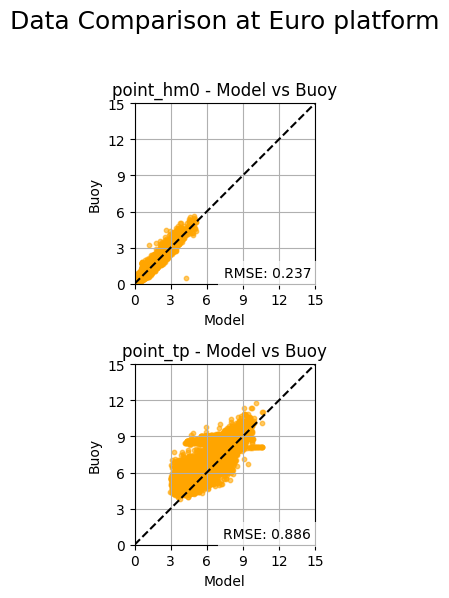

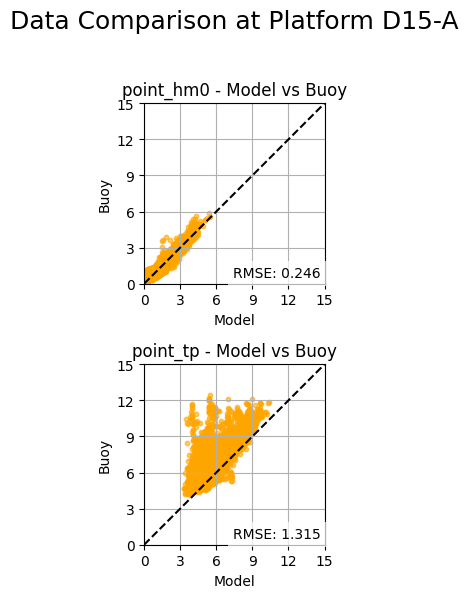

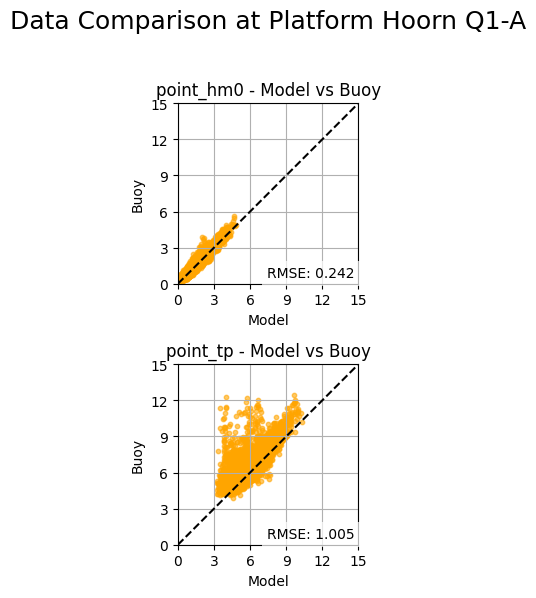

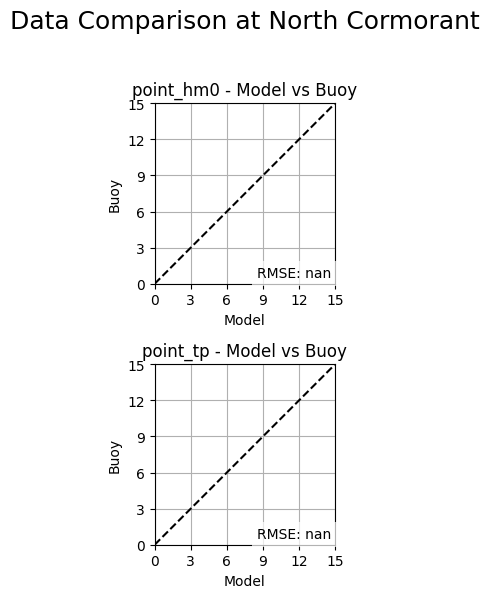

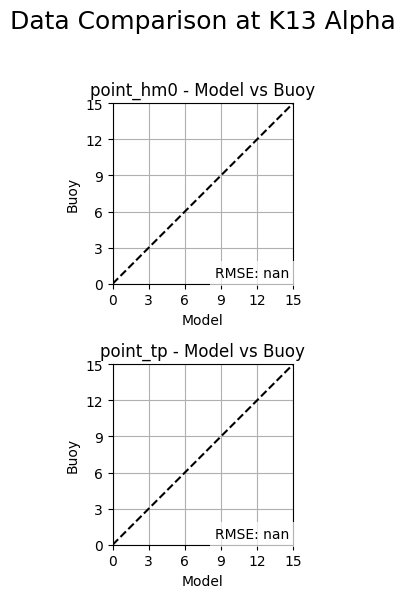

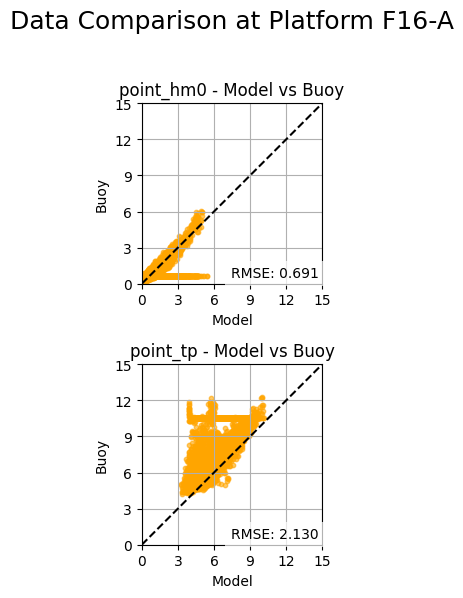

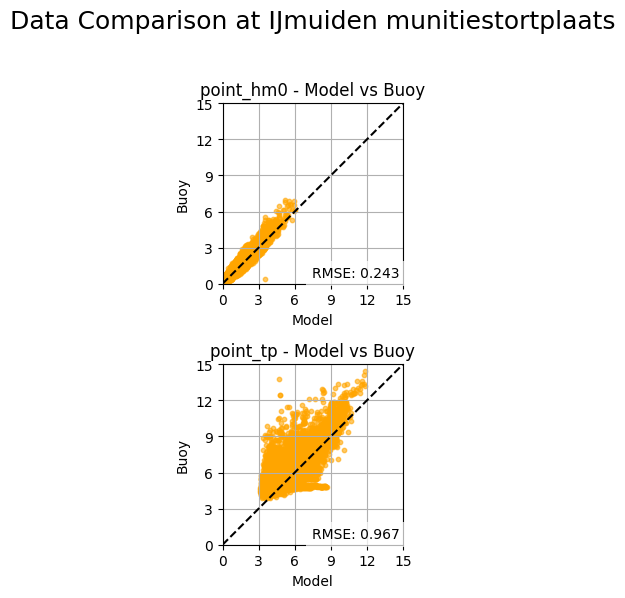

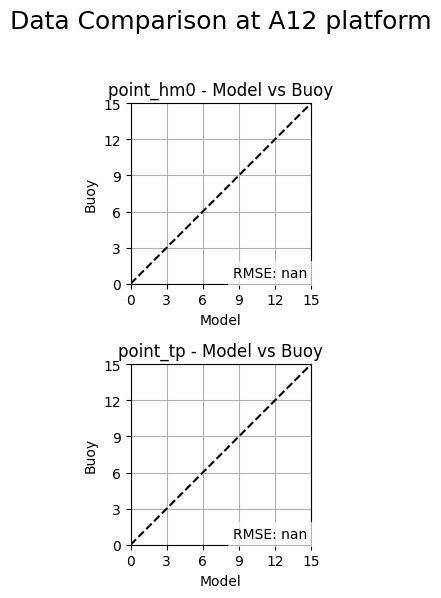

In [47]:
# SCATTER PLOTS
def scatter_plot_station_data_comparison(
    station_name,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    output_dir=None,
    show_map=True
):  
    """
    Plot optional map and scatter comparison between model, ERA5, and buoy at a station.
    """
    if model_vars is None:
        model_vars = list(model_df.get(station_name, {}).keys())

    n_rows = len(model_vars)
    fig_height = (1.5 if show_map else 0) + n_rows * 3
    fig = plt.figure(figsize=(10, fig_height))
    fig.suptitle(f'Data Comparison at {station_name}', fontsize=18, y=0.99, ha='center')

    if show_map:
        gs = gridspec.GridSpec(n_rows + 1, len(benchmarks), figure=fig, height_ratios=[1] + [3]*n_rows)
        # Map
        ax_map = fig.add_subplot(gs[0, :])
        m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                    llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=ax_map)
        m.drawcoastlines()
        m.fillcontinents(color='lightgray', lake_color='aqua')
        m.drawmapboundary(fill_color='aqua')
        lat = float(model_df[station_name]["station_y"])
        lon = float(model_df[station_name]["station_x"])
        x, y = m(lon, lat)
        m.plot(x, y, 'ro', markersize=8)
        ax_map.text(x, y, f' {station_name}', fontsize=10, color='black')
    else:
        gs = gridspec.GridSpec(n_rows, len(benchmarks), figure=fig, height_ratios=[3]*n_rows)

    for row_idx, var in enumerate(model_vars):
        model_vals = model_df[station_name].get(var)
        if model_vals is None:
            continue

        era5_var = map_variable_era5.get(var, var) if map_variable_era5 else var
        buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var

        target_row = row_idx + 1 if show_map else row_idx

        def make_square_scatter(ax, x_vals, y_vals, rmse, label_x, label_y, title, point_color):
            # Force square and fixed ticks
            ticks = [0, 3, 6, 9, 12, 15]
            min_val, max_val = min(ticks), max(ticks)

            ax.scatter(x_vals, y_vals, s=10, alpha=0.6, color=point_color)
            ax.plot([min_val, max_val], [min_val, max_val], 'k--')
            ax.set_xlim(min_val, max_val)
            ax.set_ylim(min_val, max_val)
            ax.set_aspect('equal', adjustable='box')

            ax.set_xticks(ticks)
            ax.set_yticks(ticks)

            # RMSE in bottom-right
            ax.text(0.98, 0.02, f"RMSE: {rmse:.3f}",
                    transform=ax.transAxes, fontsize=10,
                    verticalalignment='bottom', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

            ax.set_xlabel(label_x)
            ax.set_ylabel(label_y)
            ax.set_title(title)
            ax.grid(True)

        # Model vs ERA5
        if "era5" in benchmarks and era5_df and era5_var in era5_df.get(station_name, {}):
            ax1 = fig.add_subplot(gs[target_row, benchmarks.index("era5")])
            era5_vals = era5_df[station_name][era5_var]
            rmse = df_statistics[station_name][var]['RMSE']['era5'] if df_statistics else np.nan
            make_square_scatter(ax1, model_vals, era5_vals, rmse, "Model", "ERA5", f"{var} - Model vs ERA5", point_color='green')

        # Model vs Buoy
        if "buoy" in benchmarks and buoy_df and buoy_var in buoy_df.get(station_name, {}) and np.size(buoy_df[station_name][buoy_var]) == np.size(model_vals):
            ax2 = fig.add_subplot(gs[target_row, benchmarks.index("buoy")])
            buoy_vals = buoy_df[station_name][buoy_var]
            rmse = df_statistics[station_name][var]['RMSE']['buoy'] if df_statistics else np.nan
            make_square_scatter(ax2, model_vals, buoy_vals, rmse, "Model", "Buoy", f"{var} - Model vs Buoy", point_color='orange')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if output_dir:
        output_path = os.path.join(output_dir, f'Scatter_comparison_at_{station_name}.png')
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def scatter_plot_all_stations(
    station_names,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    output_dir=output_dir,
    show_map=True):

    """
    Plot time series for selected variables at all stations, comparing model, ERA5, and/or buoy data.
    Includes a map with the station locations and a side panel showing statistical metrics.
    Parameters:
        station_names (list of str): Names of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
        variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
    """
    
    for station_name in station_names:
        scatter_plot_station_data_comparison(
            station_name,
            model_df,
            era5_df=era5_df,
            buoy_df=buoy_df,
            model_vars=model_vars,
            benchmarks=benchmarks,
            map_variable_era5=map_variable_era5,
            map_variable_buoy=map_variable_buoy,
            df_statistics=df_statistics,
            output_dir=output_dir,
            show_map=show_map
        )

scatter_plot_all_stations(
    station_names=station_names,
    model_df=data_per_station,
    buoy_df=obs_data_per_station,
    model_vars=variable_list,
    benchmarks=["buoy"],
    map_variable_era5=variable_mapping_era5,
    map_variable_buoy=variable_mapping_measurements,
    df_statistics=df_statistics,
    output_dir=output_dir,
    show_map=False

)






In [43]:
#########################################################################################
# QQ Plot

def qqplot_station_data_comparison(
    station_name,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    output_dir=None,
    show_map=True,
    pinball_quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

):  
    """
    Plot map and QQ comparison between model, ERA5, and buoy at a station.
    Displays pinball loss statistics from df_statistics on the graph.
    """
    if model_vars is None:
        model_vars = list(model_df.get(station_name, {}).keys())

    # Adjust figure height based on whether we show the map
    fig_height = (2.5 if show_map else 0) + len(model_vars) * 2.5
    fig = plt.figure(figsize=(8, fig_height))
    fig.suptitle(f'Data Comparison at {station_name}', fontsize=18, y=0.97, ha='center')

    current_top = 0.95  # start just below title

    # Draw map if requested
    if show_map:
        map_ax = fig.add_axes([0.25, current_top - 0.25, 0.5, 0.2])  # centered
        m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                    llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
        m.drawcoastlines()
        m.fillcontinents(color='lightgray', lake_color='aqua')
        m.drawmapboundary(fill_color='aqua')

        lat = float(model_df[station_name]["station_y"])
        lon = float(model_df[station_name]["station_x"])
        x, y = m(lon, lat)
        m.plot(x, y, 'ro', markersize=8)
        map_ax.text(x, y, f' {station_name}', fontsize=10, color='black')

        current_top -= 0.3  # shift down for plots

    scatter_vars = model_vars

    # Centered QQ plots
    plot_height = 0.5
    vertical_space = 0.15
    plot_width = 0.7  # make single plot per variable, centered
    left = (1 - plot_width) / 2

    for row_idx, var in enumerate(scatter_vars):
        model_vals = model_df[station_name].get(var)
        if model_vals is None:
            continue

        buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var
        bottom = current_top - (row_idx + 1) * (plot_height + vertical_space)

        # Model vs Buoy QQ scatter plot
        if "buoy" in benchmarks and buoy_df and buoy_var in buoy_df.get(station_name, {}) and np.size(buoy_df[station_name][buoy_var]) == np.size(model_vals):
            buoy_vals = buoy_df[station_name][buoy_var]
            mask = ~np.isnan(model_vals) & ~np.isnan(buoy_vals)
            if np.sum(mask) > 0:
                sorted_model = np.sort(model_vals[mask])
                sorted_buoy = np.sort(buoy_vals[mask])
                min_len = min(len(sorted_model), len(sorted_buoy))
                sorted_model = sorted_model[:min_len]
                sorted_buoy = sorted_buoy[:min_len]
                ax = fig.add_axes([left, bottom, plot_width, plot_height])
                ax.scatter(sorted_buoy, sorted_model, label="Model vs Buoy", color='orange', s=10, alpha=0.7)
                ax.plot([sorted_buoy[0], sorted_buoy[-1]], [sorted_buoy[0], sorted_buoy[-1]], 'k--', lw=1, label="1:1 line")
                ax.set_xlabel("Buoy sorted values")
                ax.set_ylabel("Model sorted values")
                ax.set_title(f"{var} - Model vs Buoy QQ")
                ax.grid(True, which='both', linestyle=':', alpha=0.7)
                if pinball_quantiles:
                    q_idx = (np.array(pinball_quantiles) * (min_len - 1)).astype(int)
                    for idx in q_idx:
                        ax.axvline(sorted_buoy[idx], color='gray', linestyle='--', alpha=0.4, zorder=0)
                        ax.axhline(sorted_model[idx], color='gray', linestyle='--', alpha=0.4, zorder=0)
                ax.legend(loc='upper left')
                if df_statistics and station_name in df_statistics and var in df_statistics[station_name]:
                    pinball_lines = []
                    for stat in df_statistics[station_name][var]:
                        if stat.startswith("Pinball Loss") and "buoy" in df_statistics[station_name][var][stat]:
                            val = df_statistics[station_name][var][stat]["buoy"]
                            pinball_lines.append(f"{stat}: {val:.3f}")
                    ax.text(
                        0.98, 0.02,
                        "\n".join(pinball_lines),
                        transform=ax.transAxes,
                        fontsize=9,
                        verticalalignment='bottom',
                        horizontalalignment='right',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
                    )

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if output_dir:
        output_path = os.path.join(output_dir, f'QQ_comparison_at_{station_name}.png')
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

def qqplot_plot_all_stations(
    station_names,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    output_dir=output_dir,
    show_map=True):

    """
    Plot time series for selected variables at all stations, comparing model, ERA5, and/or buoy data.
    Includes a map with the station locations and a side panel showing statistical metrics.
    Parameters:
        station_names (list of str): Names of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
        variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
    """
    
    for station_name in station_names:
        qqplot_station_data_comparison(
            station_name,
            model_df,
            era5_df=era5_df,
            buoy_df=buoy_df,
            model_vars=model_vars,
            benchmarks=benchmarks,
            map_variable_era5=map_variable_era5,
            map_variable_buoy=map_variable_buoy,
            df_statistics=df_statistics,
            output_dir=output_dir,
            show_map=show_map
        )

qqplot_plot_all_stations(
    station_names=station_names,
    model_df=data_per_station,
    buoy_df=obs_data_per_station,
    model_vars=variable_list,
    benchmarks=["buoy"],
    map_variable_era5=variable_mapping_era5,
    map_variable_buoy=variable_mapping_measurements,
    df_statistics=df_statistics,
    output_dir=output_dir,
    show_map=False
)



/scratch-local/72649/ipykernel_3042742/3855462612.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


In [44]:
def plot_acf_model_buoy(
    station_name,
    model_dict,
    obs_dict,
    variable,
    variable_mapping_measurements,
    save_path=output_dir,
    lags=100,
    figsize=(10, 5)
):
    """
    Plot the autocorrelation function (ACF) for model and buoy data for a given station and variable.

    Parameters:
        station_name (str): Name of the station.
        model_dict (dict): Model data dictionary.
        obs_dict (dict): Observational data dictionary.
        variable (str): Model variable name (e.g., 'point_hm0').
        variable_mapping_measurements (dict): Mapping from model variable to measurement variable.
        lags (int): Number of lags for ACF.
        figsize (tuple): Figure size.
    """

    stats_dir = os.path.join(save_path, "stats")
    if not os.path.exists(stats_dir):
        os.makedirs(stats_dir)
    # Get model and measurement variable names
    model_var = variable
    meas_var = variable_mapping_measurements.get(variable, variable)

    # Extract data
    model_vals = model_dict.get(station_name, {}).get(model_var, None)
    obs_vals = obs_dict.get(station_name, {}).get(meas_var, None)

    if model_vals is None or obs_vals is None:
        print(f"Data not found for station '{station_name}' and variable '{variable}'.")
        return

    # Convert to numpy arrays and drop NaNs
    model_vals = np.asarray(model_vals)
    obs_vals = np.asarray(obs_vals)

    # Ensure both arrays are float type for np.isfinite
    model_vals = model_vals.astype(float)
    obs_vals = obs_vals.astype(float)

    mask = np.isfinite(model_vals) & np.isfinite(obs_vals)
    model_vals = model_vals[mask]
    obs_vals = obs_vals[mask]

    if len(model_vals) == 0 or len(obs_vals) == 0:
        print(f"No valid data for ACF plot at station '{station_name}' for variable '{variable}'.")
        return

    # Compute ACFs
    acf_model = acf(model_vals - np.nanmean(model_vals), nlags=lags, fft=True)
    acf_obs = acf(obs_vals - np.nanmean(obs_vals), nlags=lags, fft=True)

    # Plot
    plt.figure(figsize=figsize)
    plt.stem(range(lags + 1), acf_model, linefmt='b-', markerfmt='bo', basefmt=' ', label='Model')
    plt.stem(range(lags + 1), acf_obs, linefmt='orange', markerfmt='o', basefmt=' ', label='Buoy')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(f'ACF for {variable} at {station_name} (Model vs Buoy)')
    plt.legend(['Model', 'Buoy'])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(stats_dir, f'acf_{station_name}_{variable}.png'), dpi=300)
    plt.close()

def plot_acf_model_buoy_all_stations(
    model_dict,
    obs_dict,
    variable,
    variable_mapping_measurements,
    save_path=output_dir,
    lags=100,
    figsize=(10, 5)
):
    """
    Plot the autocorrelation function (ACF) for model and buoy data across all stations for a given variable.

    Parameters:
        model_dict (dict): Model data dictionary.
        obs_dict (dict): Observational data dictionary.
        variable (str): Model variable name (e.g., 'point_hm0').
        variable_mapping_measurements (dict): Mapping from model variable to measurement variable.
        lags (int): Number of lags for ACF.
        figsize (tuple): Figure size.
    """
    for station_name in model_dict.keys():
        plot_acf_model_buoy(
            station_name,
            model_dict,
            obs_dict,
            variable,
            variable_mapping_measurements,
            save_path=output_dir,
            lags=lags,
            figsize=figsize
        )

plot_acf_model_buoy_all_stations(
    model_dict=data_per_station,
    obs_dict=obs_data_per_station,
    variable='point_hm0',
    variable_mapping_measurements=variable_mapping_measurements,
    save_path=output_dir,
    lags=100,
    figsize=(10, 5)
)

plot_acf_model_buoy_all_stations(
    model_dict=data_per_station,
    obs_dict=obs_data_per_station,
    variable='point_tp',
    variable_mapping_measurements=variable_mapping_measurements,
    save_path=output_dir,
    lags=100,
    figsize=(10, 5)
)


No valid data for ACF plot at station 'North Cormorant' for variable 'point_hm0'.
No valid data for ACF plot at station 'K13 Alpha' for variable 'point_hm0'.
No valid data for ACF plot at station 'A12 platform' for variable 'point_hm0'.
No valid data for ACF plot at station 'North Cormorant' for variable 'point_tp'.
No valid data for ACF plot at station 'K13 Alpha' for variable 'point_tp'.
No valid data for ACF plot at station 'A12 platform' for variable 'point_tp'.


In [45]:
# # plot bed level - Hurrywave
# fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

# im = modig['zb'].plot(ax =ax,
#                  x="x",
#                  y="y",
#                  cmap = "terrain",
#                  vmin = -100, vmax = 20,
#                  cbar_kwargs={'label': 'zb [m]'})

# # plt.scatter(his.station_x, his.station_y, color='k')
# # for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
# #     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

# ax.set_aspect('equal', adjustable='box')
# ax.set_title('Hurrywave domain', fontsize = 15)

# # ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# # ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
# ax.set_xlabel('Lon [deg]')
# ax.set_ylabel('Lat [deg]')

# output_path = os.path.join(output_dir, 'bathy3.png')
# fig.savefig(output_path, dpi=300, bbox_inches='tight')

# # plot wave height - Hurrywave
# fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

# im = modig['Hm0'].isel(time=-97).plot(ax =ax,
#                  x="x",
#                  y="y",
#                  cmap = "viridis",
#                  vmin = 0, vmax = 10,
#                  cbar_kwargs={'label': 'Hs [m]'})

# # plt.scatter(his.station_x, his.station_y, color='k')
# # for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
# #     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

# ax.set_aspect('equal', adjustable='box')
# ax.set_title('Hurrywave domain - Significant wave height', fontsize = 15)

# # ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# # ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
# ax.set_xlabel('Lon [deg]')
# ax.set_ylabel('Lat [deg]') 

# #plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
# #xr_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

# output_path = os.path.join(output_dir, 'waveheight3.png')
# fig.savefig(output_path, dpi=300, bbox_inches='tight')

# # plot wave period - Hurrywave
# fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

# im = modig['Tp'].isel(time=-97).plot(ax =ax,
#                  x="x",
#                  y="y",
#                  cmap = "viridis",
#                  vmin = 4, vmax = 13,
#                  cbar_kwargs={'label': 'Tp [m]'})

# # plt.scatter(his.station_x, his.station_y, color='k')
# # for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
# #     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

# ax.set_aspect('equal', adjustable='box')
# ax.set_title('Hurrywave domain - Peak wave period', fontsize = 15)

# # ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# # ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
# ax.set_xlabel('Lon [deg]')
# ax.set_ylabel('Lat [deg]')

# # plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
# #xr_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

# output_path = os.path.join(output_dir, 'waveperiod3.png')
# fig.savefig(output_path, dpi=300, bbox_inches='tight')


# # plot wave direction - Hurrywave
# fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

# im = modig['DIR'].isel(time=-97).plot(ax =ax,
#                  x="x",
#                  y="y",
#                  cmap = "viridis",
#                  cbar_kwargs={'label': 'DIR [degrees]'})

# # plt.scatter(his.station_x, his.station_y, color='k')
# # for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
# #     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

# ax.set_aspect('equal', adjustable='box')
# ax.set_title('Hurrywave domain - Wave direction', fontsize = 15)

# # ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# # ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
# ax.set_xlabel('Lon [deg]')
# ax.set_ylabel('Lat [deg]')

# # plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
# #xr_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

# output_path = os.path.join(output_dir, 'direction3.png')
# fig.savefig(output_path, dpi=300, bbox_inches='tight')

In [46]:
n_boot = 2000 # Number of bootstrap samples
block_size = 72 # Size of each block for block bootstrap [hours]

def block_bootstrap_metric(obs, pred, metric_func, n_boot=n_boot, block_size=block_size):
    """Block bootstrap for a metric, preserving autocorrelation."""
    obs, pred = _filter_valid_pairs(obs, pred)
    n = len(obs)
    n_blocks = int(np.ceil(n / block_size))
    boot_values = []
    for _ in range(n_boot):
        idx_blocks = np.random.randint(0, n_blocks, size=n_blocks)
        idx = np.concatenate([range(i*block_size, min((i+1)*block_size, n))
                              for i in idx_blocks])
        boot_values.append(metric_func(obs[idx], pred[idx]))
    return np.array(boot_values)

def bootstrap_bias_test(obs, model, block_size=block_size, n_boot=n_boot):
    """Bootstrap test for bias being negative (reject H0: bias >= 0)."""
    boot_vals = block_bootstrap_metric(obs, model, bias, block_size=block_size, n_boot=n_boot)
    observed_bias = bias(obs, model)
    ci = np.percentile(boot_vals, [2.5, 97.5])
    # One-sided: p = fraction of bootstrap biases >= 0
    p_val = (boot_vals >= 0).mean()
    return observed_bias, ci, p_val, boot_vals

def plot_bootstrap_distribution(values, observed_val, ci, p_value, title, units, save_path, n_boot=n_boot, test_statement=""):
    """Plot histogram with CI and test statement instead of only p-value."""
    plt.figure(figsize=(6,4))
    plt.hist(values, bins=40, color='steelblue', alpha=0.7)
    plt.axvline(observed_val, color='red', linestyle='-', label=f"Observed = {observed_val:.4f}{units}")
    plt.axvline(ci[0], color='k', linestyle='--', label=f"95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
    plt.axvline(ci[1], color='k', linestyle='--')

    # Replace plain p-value with test hypothesis text
    # plt.text(
    #     0.98, 0.98,
    #     f"{test_statement}\n(p = {p_value:.3e})" if p_value > 1/n_boot else f"{test_statement}\n(p < {1/n_boot:.3e})",
    #     transform=plt.gca().transAxes, fontsize=10,
    #     verticalalignment='top', horizontalalignment='right',
    #     bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
    # )
    plt.xlabel(f"{title} ({units})")
    plt.ylabel("Frequency")
    plt.title(f"{title} Bootstrap Distribution")
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def format_pval(p, n_boot):
    return f"p = {p:.3e}" if p > 1/n_boot else f"p < {1/n_boot:.3e}"

def plot_bootstrap_means_and_stdevs(obs, pred, station, variable, save_path, block_size=block_size):
    """
    Plot block means and standard deviations of obs and pred.
    Shows two subplots: left = means, right = standard deviations.
    """

    # Filter valid pairs
    obs, pred = _filter_valid_pairs(obs, pred)
    n = len(obs)
    n_blocks = int(np.ceil(n / block_size))

    # Store block means and stds
    block_means_pred = []
    block_stds_pred = []
    block_means_obs = []
    block_stds_obs = []

    for i in range(n_blocks):
        start = i * block_size
        end = min((i + 1) * block_size, n)
        if end > start:
            block_obs = obs[start:end]
            block_pred = pred[start:end]
            block_means_pred.append(np.mean(block_pred))
            block_stds_pred.append(np.std(block_pred, ddof=1))
            block_means_obs.append(np.mean(block_obs))
            block_stds_obs.append(np.std(block_obs, ddof=1))

    block_means_pred = np.array(block_means_pred)
    block_stds_pred = np.array(block_stds_pred)
    block_means_obs = np.array(block_means_obs)
    block_stds_obs = np.array(block_stds_obs)

    if variable == 'point_hm0':
        unit = 'm'
    elif variable == 'point_tp':
        unit = 's'
    # === Plot ===
    fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=False)

    # Top left: mean of model predictions (blue)
    axes[0, 0].plot(block_means_pred, marker="o", linestyle="-", color="blue")
    axes[0, 0].set_title("Block Means (Model Prediction)")
    axes[0, 0].set_xlabel("Block index")
    axes[0, 0].set_ylabel(f"Mean (model) [{unit}]")

    # Bottom left: stddev of model predictions (blue)
    axes[1, 0].plot(block_stds_pred, marker="o", linestyle="-", color="blue")
    axes[1, 0].set_title("Block Std Dev (Model Prediction)")
    axes[1, 0].set_xlabel("Block index")
    axes[1, 0].set_ylabel(f"Std Dev (model) [{unit}]")

    # Top right: mean of observations (orange)
    axes[0, 1].plot(block_means_obs, marker="o", linestyle="-", color="orange")
    axes[0, 1].set_title("Block Means (Observation)")
    axes[0, 1].set_xlabel("Block index")
    axes[0, 1].set_ylabel(f"Mean (obs) [{unit}]")

    # Bottom right: stddev of observations (orange)
    axes[1, 1].plot(block_stds_obs, marker="o", linestyle="-", color="orange")
    axes[1, 1].set_title("Block Std Dev (Observation)")
    axes[1, 1].set_xlabel("Block index")
    axes[1, 1].set_ylabel(f"Std Dev (obs) [{unit}]")

    # Add a vertical line between left and right plots
    for ax in axes[:, 0]:
        ax.axvline(x=-0.5, color="gray", linestyle="--", linewidth=1)
    for ax in axes[:, 1]:
        ax.axvline(x=-0.5, color="gray", linestyle="--", linewidth=1)

    fig.suptitle(f"Block Bootstrap Diagnostics at {station} for {variable}")
    outpath = os.path.join(save_path, f"block_bootstrap_diagnostic_{station}_{variable}.png")
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.close()

def null_block_permutation_metric(obs, model, metric_func, block_size=block_size, n_boot=n_boot):
    n = len(obs)
    n_blocks = int(np.ceil(n / block_size))
    blocks = [slice(i*block_size, min((i+1)*block_size, n)) for i in range(n_blocks)]
    vals = np.empty(n_boot)
    for b in range(n_boot):
        order = np.random.permutation(n_blocks)
        idx = np.concatenate([np.arange(blocks[j].start, blocks[j].stop) for j in order])
        # IMPORTANT: permute ONLY the model relative to fixed obs
        vals[b] = metric_func(obs, model[idx])
    return vals

def null_shift_metric(obs, model, metric_func, n_boot=2000, min_shift=24):
    n = len(obs)
    vals = np.empty(n_boot)
    for b in range(n_boot):
        # random shift that’s not tiny (avoid near-alignment)
        k = np.random.randint(min_shift, n - min_shift)
        model_shifted = np.roll(model, k)
        vals[b] = metric_func(obs, model_shifted)
    return vals

def null_larger_than(obs, model, metric_func, threshold, n_boot=n_boot, block_size=block_size, tail="left"):
    """
    Null distribution under H0: metric >= threshold (tail="left")
    or H0: metric <= threshold (tail="right").

    Uses block bootstrap to resample obs/model pairs and recompute the metric.
    The bootstrap distribution is recentered around the threshold so that
    permutation_p_value can be applied in the same way as for other nulls.
    """
    n = len(obs)
    n_blocks = int(np.ceil(n / block_size))
    boot_vals = np.empty(n_boot)

    for b in range(n_boot):
        idx_blocks = np.random.randint(0, n_blocks, size=n_blocks)
        idx = np.concatenate([range(i*block_size, min((i+1)*block_size, n))
                              for i in idx_blocks])
        boot_vals[b] = metric_func(obs[idx], model[idx])

    # Recenter distribution so mean sits at threshold
    null_dist = boot_vals - np.mean(boot_vals) + threshold

    return null_dist

def permutation_p_value(null_distribution, observed_val, tail="left"):
    n_perm = len(null_distribution)
    
    if tail == "left":
        p = (null_distribution <= observed_val).mean()
    elif tail == "right":
        p = (null_distribution >= observed_val).mean()
    elif tail == "two-sided":
        p = (np.abs(null_distribution) >= np.abs(observed_val)).mean()
    else:
        raise ValueError("tail must be 'left', 'right', or 'two-sided'")
    
    # Avoid returning string
    if p == 0:
        p = 1 / n_perm
    return p

def autocorrel_with_metrics(model_dict, obs_dict, output_dir, variable_list, block_size=block_size, n_boot=n_boot):
    stats_dir = os.path.join(output_dir, "stats")
    os.makedirs(stats_dir, exist_ok=True)

    for station in model_dict.keys():
        for model_var in variable_list:
            if model_var not in model_dict[station]:
                continue

            buoy_var = map_variable_measurements(model_var)
            model = np.array(model_dict[station][model_var])
            obs = np.array(obs_dict[station][buoy_var])

            # === Check 1: non-empty & same length ===
            if model.size == 0 or obs.size == 0:
                print(f"Skipping {station} {model_var}: no data")
                continue
            if len(model) != len(obs):
                print(f"Skipping {station} {model_var}: mismatched lengths")
                continue
            if np.all(np.isnan(model)) or np.all(np.isnan(obs)):
                print(f"Skipping {station} {model_var}: all NaNs")
                continue

            # === Check 2: time spacing is hourly ===
            if "time" in model_dict[station]:
                times = np.array(model_dict[station]["time"])
                diffs = np.diff(times).astype("timedelta64[h]").astype(int)
                mask = np.insert(diffs == 1, 0, True)  # keep first value
                times = times[mask]
                model = model[mask]
                obs = obs[mask]
                do_acf = True
            # === Drop NaNs ===
            mask = ~np.isnan(model) & ~np.isnan(obs)
            model = model[mask]
            obs = obs[mask]

            if model.size == 0:
                print(f"Skipping {station} {model_var}: no valid pairs after NaN removal")
                continue

            # === 1. Compute errors ===
            errors = model - obs
            n_original = len(errors)

            # === 2. Lag-1 autocorrelation ===
            if do_acf:
                acf_vals = acf(errors, nlags=40, fft=True)
                r1 = acf_vals[1]
            else:
                acf_vals = np.array([np.nan])
                r1 = np.nan

            # === 3. Effective sample size ===
            if not np.isnan(r1):
                neff = n_original * (1 - r1) / (1 + r1)
            else:
                neff = n_original

            # === 4. Bias t-test ===
            mean_bias = np.mean(errors)
            std_error = np.std(errors, ddof=1) / np.sqrt(neff)
            t_stat = mean_bias / std_error
            df = neff - 1
            p_val_bias = 2 * stats.t.sf(np.abs(t_stat), df)
            ci_bias = (
                mean_bias - stats.t.ppf(0.975, df) * std_error,
                mean_bias + stats.t.ppf(0.975, df) * std_error
            )

            # === 5. Bootstrap metrics ===
            try:
                # === Bias bootstrap test ===
                bias_val, ci_bias, p_val_bias, bias_boot = bootstrap_bias_test(obs, model, block_size=block_size, n_boot=n_boot)
                if model_var == "point_hm0":
                    plot_bootstrap_distribution(bias_boot, bias_val, ci_bias, p_val_bias,
                                                f"Bias at {station} for {model_var}", " m",
                                                os.path.join(stats_dir, f"bias_bootstrap_{station}_{model_var}.png"),
                                                n_boot=n_boot,
                                                test_statement="Testing Bias < 0 (rejecting positive bias)")
                elif model_var == "point_tp":
                    plot_bootstrap_distribution(bias_boot, bias_val, ci_bias, p_val_bias,
                                                f"Bias at {station} for {model_var}", " s",
                                                os.path.join(stats_dir, f"bias_bootstrap_{station}_{model_var}.png"),
                                                n_boot=n_boot,
                                                test_statement="Testing Bias < 0 (rejecting positive bias)")

                if model_var == "point_hm0":
                    rmse_threshold = 0.5
                    si_threshold = 0.4
                elif model_var == "point_tp":
                    rmse_threshold = 1.0
                    si_threshold = 0.4

                # === Plot means and stddevs to verify if they are stationary ===
                plot_bootstrap_means_and_stdevs(obs_dict[station][buoy_var].values, model_dict[station][model_var], station, model_var,stats_dir, block_size=block_size)

                # RMSE bootstrap test
                rmse_boot = block_bootstrap_metric(obs, model, rmse, block_size=block_size, n_boot=n_boot)
                ci_rmse = np.percentile(rmse_boot, [2.5, 97.5])
                rmse_val = rmse(obs, model)
                null_vals_rmse = null_larger_than(obs, model, rmse, rmse_threshold, n_boot=n_boot, block_size=block_size, tail="left")
                p_val_rmse = permutation_p_value(null_vals_rmse, rmse_val, tail="left")

                plot_bootstrap_distribution(rmse_boot, rmse_val, ci_rmse, p_val_rmse,
                                            f"RMSE at {station} for {model_var}", " m" if model_var=="point_hm0" else " s",
                                            os.path.join(stats_dir, f"rmse_bootstrap_{station}_{model_var}.png"),
                                            n_boot=n_boot,
                                            test_statement=f"Testing RMSE < {rmse_threshold}")



                # Scatter Index bootstrap test
                si_boot = block_bootstrap_metric(obs, model, scatter_index, block_size=block_size, n_boot=n_boot)
                ci_si = np.percentile(si_boot, [2.5, 97.5])
                si_val = scatter_index(obs, model)
                null_vals_si = null_larger_than(obs, model, scatter_index, si_threshold, n_boot=n_boot, block_size=block_size, tail="left")
                p_val_si = permutation_p_value(null_vals_si, si_val, tail="left")

                plot_bootstrap_distribution(si_boot, si_val, ci_si, p_val_si,
                                            f"Scatter Index at {station} for {model_var}", " -",
                                            os.path.join(stats_dir, f"scatter_index_bootstrap_{station}_{model_var}.png"),
                                            n_boot=n_boot,
                                            test_statement=f"Testing SI < {si_threshold}")

            except ValueError as e:
                print(f"Bootstrap skipped for {station} {model_var}: {e}")
                continue

            # === Print results ===
            print(f"\n=== Results at {station} for {model_var} ===")
            print(f"Original sample size: {n_original}")
            print(f"Lag-1 autocorrelation: {r1:.3f}")
            print(f"Effective sample size: {neff:.0f}")

            units = "m" if model_var=="point_hm0" else "s"

            print(f"Bias: {bias_val:.4f} {units}, 95% CI: [{ci_bias[0]:.4f}, {ci_bias[1]:.4f}] {units}, "
                f"Test: H0: Bias >= 0, {format_pval(p_val_bias, n_boot)}")

            print(f"RMSE: {rmse_val:.4f} {units}, 95% CI: [{ci_rmse[0]:.4f}, {ci_rmse[1]:.4f}] {units}, "
                f"Test: H0: RMSE >= {rmse_threshold}, {format_pval(p_val_rmse, n_boot)}")

            print(f"Scatter Index: {si_val:.4f}, 95% CI: [{ci_si[0]:.4f}, {ci_si[1]:.4f}], "
                f"Test: H0: SI >= {si_threshold}, {format_pval(p_val_si, n_boot)}")

            # === 7. Plot ACF ===
            if do_acf:
                plt.figure(figsize=(8, 5))
                plt.stem(range(len(acf_vals)), acf_vals)
                plt.xlabel("Lag (hours)")
                plt.ylabel(f"Autocorrelation at {station} for {model_var}")
                plt.title(f"Autocorrelation Function of Error Series at {station} for {model_var}")
                textstr = '\n'.join((
                    f"n original = {n_original:,}",
                    f"r1 = {r1:.3f}",
                    f"n_eff = {neff:.0f}"
                ))
                plt.text(
                    0.95, 0.85, textstr, transform=plt.gca().transAxes,
                    fontsize=10, verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
                )
                plt.axhline(0, color='k', lw=1)
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.tight_layout()
                plt.savefig(os.path.join(stats_dir, f"acf_error_series_{station}_{model_var}.png"), dpi=300)
                plt.close()

autocorrel_with_metrics(data_per_station, 
                        obs_data_per_station, 
                        output_dir, 
                        variable_list)


=== Results at Euro platform for point_hm0 ===
Original sample size: 22238
Lag-1 autocorrelation: 0.824
Effective sample size: 2149
Bias: -0.1400 m, 95% CI: [-0.1503, -0.1297] m, Test: H0: Bias >= 0, p < 5.000e-04
RMSE: 0.2381 m, 95% CI: [0.2287, 0.2472] m, Test: H0: RMSE >= 0.5, p < 5.000e-04
Scatter Index: 0.1841, 95% CI: [0.1758, 0.1929], Test: H0: SI >= 0.4, p < 5.000e-04

=== Results at Euro platform for point_tp ===
Original sample size: 22238
Lag-1 autocorrelation: 0.895
Effective sample size: 1233
Bias: -0.5868 s, 95% CI: [-0.6311, -0.5435] s, Test: H0: Bias >= 0, p < 5.000e-04
RMSE: 0.8856 s, 95% CI: [0.8112, 0.9697] s, Test: H0: RMSE >= 1.0, p < 5.000e-04
Scatter Index: 0.1364, 95% CI: [0.1249, 0.1486], Test: H0: SI >= 0.4, p < 5.000e-04

=== Results at Platform D15-A for point_hm0 ===
Original sample size: 7980
Lag-1 autocorrelation: 0.864
Effective sample size: 584
Bias: -0.0401 m, 95% CI: [-0.0679, -0.0150] m, Test: H0: Bias >= 0, p = 1.000e-03
RMSE: 0.2462 m, 95% CI: [0.

KeyboardInterrupt: 